In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

<div style="background-color: orange; color: white; border-left: 6px solid #97cca5; padding: 10px; font-family: Verdana; border-color:white;">
    <h3>Content</h3>
</div>
<div style="display: flex; align-items: flex-start; padding: 0px;">


<div style="flex: 1; padding: 0px; width:50%; background-color: #fccf03;">
    <img src="https://blog.tipranks.com/wp-content/uploads/2024/04/shutterstock_1056810860-750x406.jpg" width="700" height="100"/>
</div>

<div style="flex: 2; background-color: #fccf03; color: #fc6500; border-left: 6px solid yellow; padding: 0px; font-size: 12px; font-family: Verdana; width:50%">
    <strong>
    <ul>
        <li>Data Exploration</li>
        <li>Visualization
            <ul>
                <li>Line Chart - Historical View</li>
                <li>Line Chart - Mechanism of Day</li>
                <li>Plot Daily Return</li>
                <li>Histogram Daily Return</li>
            </ul>
        <li>Feature Engineering</li>
        <li>Impute Nan Values</li>
        <li>Plot Imputed Features</li>
        <li>Predict Close Price</li>
        <li>1 - Use [MA_for_60_days_Close, Daily_Return, RSI, MACD, MACD_signal, MACD_hist, BB_upper, BB_middle, BB_lower] features to Predict Close Price</li>
        <li>1 - Plot First Approach Result</li>
        <li>2 - LSTM Result Using Only Close feature to Predict Close Price</li>
        <li>Visualize Train and Test Dataset on Line Chart</li>
        <li>Select Window Size for Sliding Window Approach</li>
        <li>Sliding Window Approach on Raw Data</li>
        <li>Sliding Window Approach on Meachanism of 60 Day Data</li>
        <li>Result : 100 is selected as good window sizes</li>
        <li>Make Prediction</li>
        <li>2 - Plot Second Approach Result</li>
        <li>3 - LightGBM Model</li>
        <li>3 - Plot Third Approach Result</li>
    </ul>
    </strong>
</div>
</div>

In [2]:
gold_df = pd.read_csv("gold.csv")

In [3]:
gold_df

Date    Open     High      Low   Close  Volume Currency
0     2000-01-04   289.5   289.50   280.00   283.7   21621      USD
1     2000-01-05   283.7   285.00   281.00   282.1   25448      USD
2     2000-01-06   281.6   282.80   280.20   282.4   19055      USD
3     2000-01-07   282.5   284.50   282.00   282.9   11266      USD
4     2000-01-10   282.4   283.90   281.80   282.7   30603      USD
...          ...     ...      ...      ...     ...     ...      ...
5698  2022-08-29  1748.4  1757.90  1731.40  1749.7  156220      USD
5699  2022-08-30  1749.8  1752.80  1732.90  1736.3  130664      USD
5700  2022-08-31  1735.5  1738.00  1720.60  1726.2  176731      USD
5701  2022-09-01  1723.0  1723.00  1699.10  1709.3  198618      USD
5702  2022-09-02  1707.9  1729.45  1707.05  1723.0       0      USD

[5703 rows x 7 columns]

In [4]:
gold_df.isnull().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

In [5]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703 entries, 0 to 5702
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5703 non-null   object 
 1   Open      5703 non-null   float64
 2   High      5703 non-null   float64
 3   Low       5703 non-null   float64
 4   Close     5703 non-null   float64
 5   Volume    5703 non-null   int64  
 6   Currency  5703 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 312.0+ KB


In [6]:
gold_df.nunique()

Date        5703
Open        4364
High        4414
Low         4375
Close       4445
Volume      5594
Currency       1
dtype: int64

In [7]:
print(f"is there any duplicate row : {gold_df.duplicated().any()}")
print(gold_df[gold_df.duplicated()])

is there any duplicate row : False
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Currency]
Index: []


In [8]:
gold_df.drop(columns=["Currency"], inplace=True)

In [9]:
gold_df.describe()

Open         High          Low        Close         Volume
count  5703.000000  5703.000000  5703.000000  5703.000000    5703.000000
mean   1040.382816  1048.339181  1031.863169  1040.298282  139141.669297
std     518.733377   522.353946   514.455903   518.524020  102537.449058
min     256.600000   259.400000   255.100000   256.600000       0.000000
25%     459.850000   463.900000   457.450000   460.500000   52938.500000
50%    1188.800000  1198.000000  1179.700000  1188.700000  126006.000000
75%    1381.400000  1392.750000  1368.100000  1383.050000  193109.000000
max    2076.400000  2089.200000  2049.000000  2069.400000  816531.000000

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 50%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Line Chart - Historical View</h2>
</div>

In [10]:
def plot_historical_line(df, features, date_feature_name):
    nrow = int(np.ceil(len(features)/2))
    fig, axs = plt.subplots(nrow, 2, figsize=(15, 15))
    for i, feature in enumerate(features):
        row = i // 2
        col = i % 2
        gold_df.set_index(date_feature_name)[feature].plot(ax=axs[row, col], color="orange", lw=1.5)
        axs[row, col].set_ylabel(feature)
        axs[row, col].set_xlabel("Date")   
    if(len(features)%2 == 1):
        axs[(nrow-1), 1].axis('off')
    plt.tight_layout()
    plt.show()

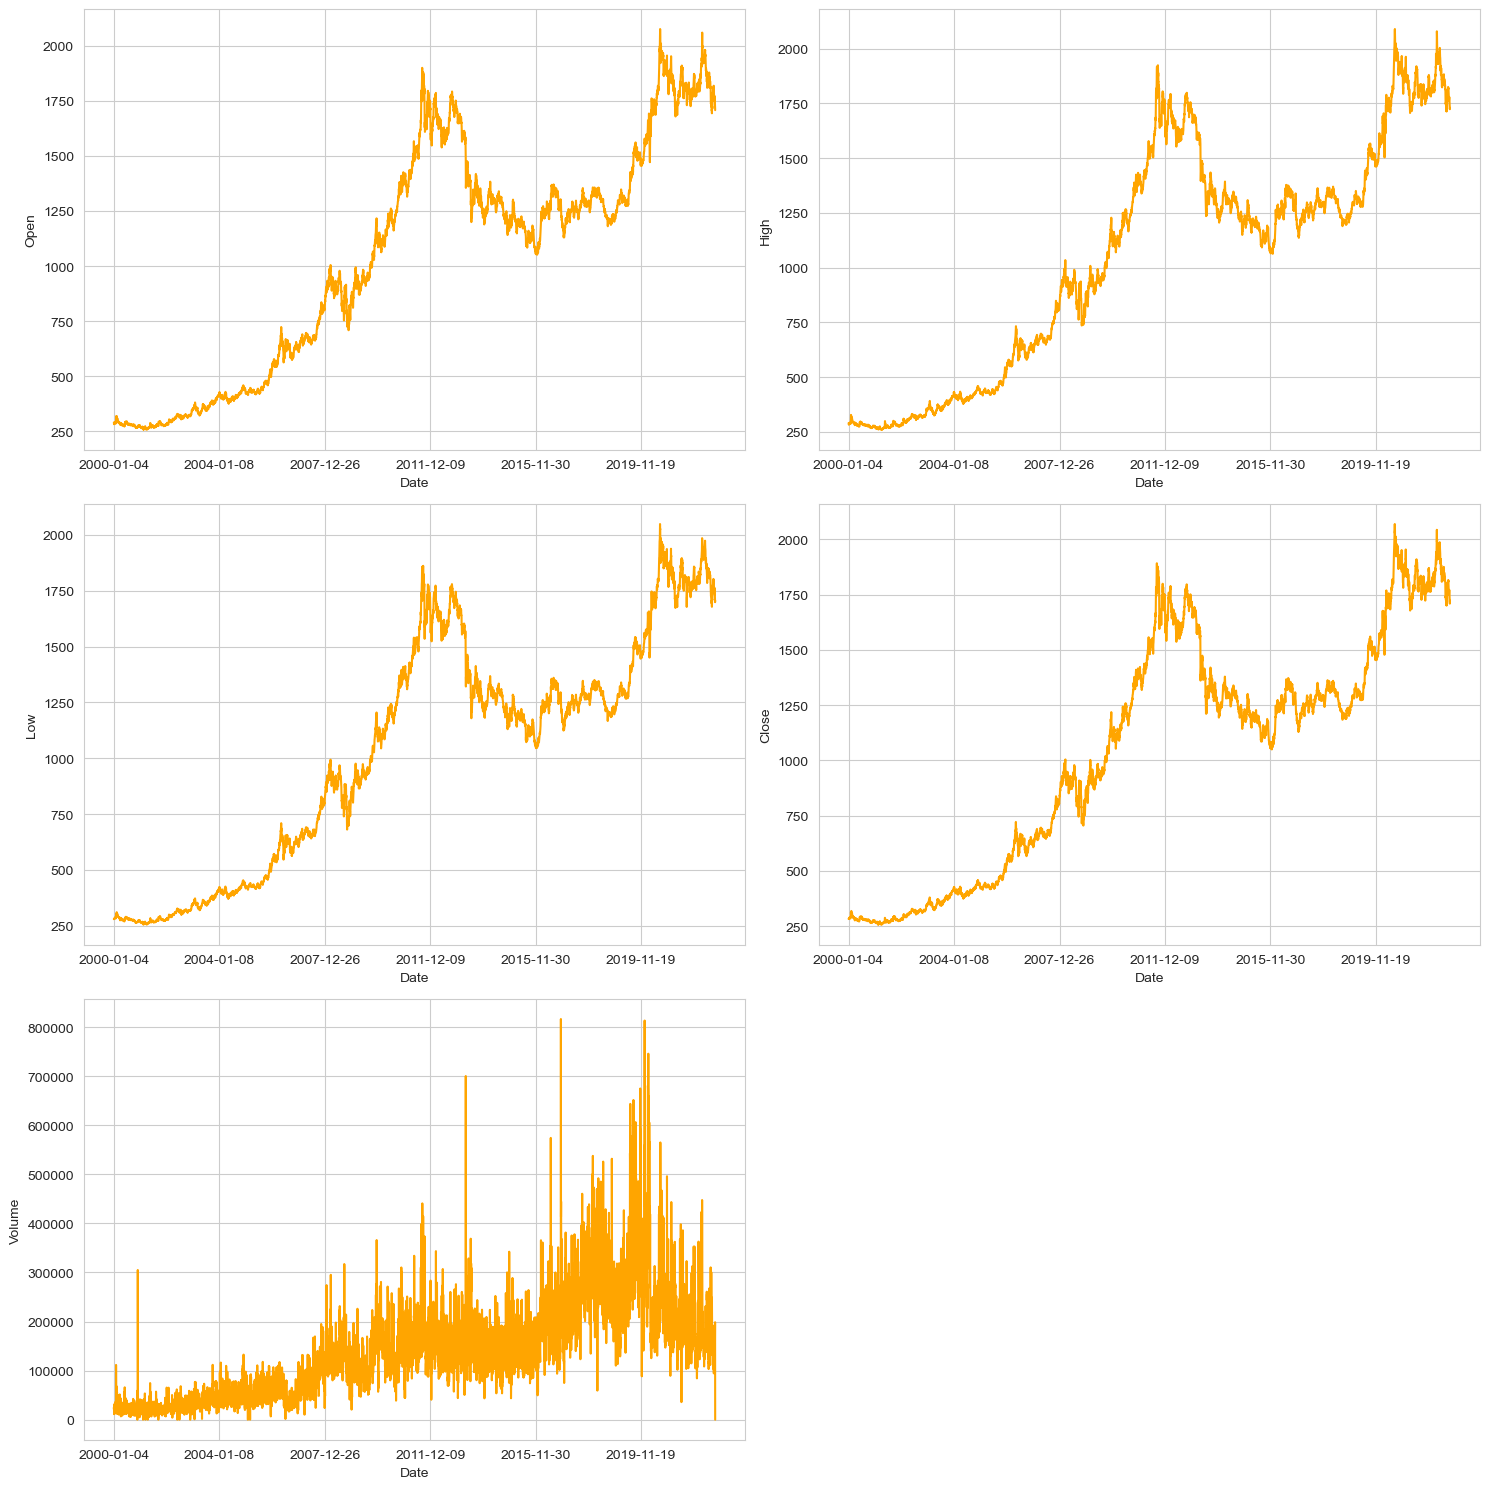

In [11]:
plot_historical_line(gold_df, gold_df.columns[1:], "Date")

In [12]:
def plot_historical_line_one(df, features, date_feature_name):
    num_colors = len(features)
    colors = cm.viridis(np.linspace(0, 1, num_colors))
    plt.figure(figsize=(15, 8))
    for i, feature in enumerate(features):
        df.set_index(date_feature_name)[feature].plot(color=colors[i], label=feature, lw=1.5)
    plt.ylabel('Values')
    plt.xlabel('Date')
    plt.legend(loc='upper right')
    plt.show()

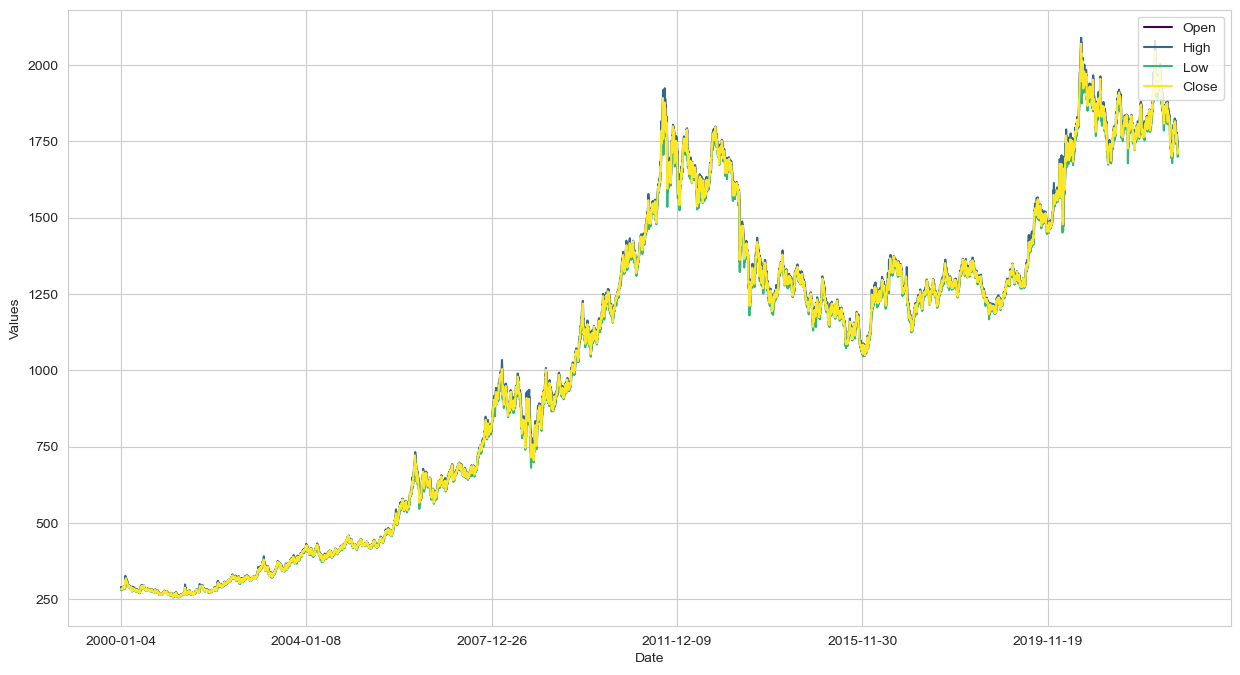

In [13]:
plot_historical_line_one(gold_df, gold_df.columns[1:-1], "Date")

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 50%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Line Chart - Mechanism of Day</h2>
</div>

In [14]:
def plot_ma_line(df, features, date_feature_name:str, ma_day:list):
    if(len(features)==0 or len(ma_day)==0 or len(df)==0):
        return
    if(not set(features).issubset(df.columns)):
        return
    nrow = int(np.ceil(len(features)/2))
    ncol = 2
    fig, axs = plt.subplots(nrow, ncol, figsize=(40, 10))
    num_colors = len(ma_day)
    colors = cm.autumn_r(np.linspace(0, 1, num_colors)) # Blues
    for i, feature in enumerate(features):
        row = i // 2
        col = i % 2
        ma_df=pd.DataFrame(data=df[date_feature_name], columns=[date_feature_name])
        df.set_index(date_feature_name)[feature].plot(ax=axs[row, col], color="orange", label=feature, lw=1)
        for ind, ma in enumerate(ma_day):
            column_name = f"MA_for_{ma}_days"
            column_name = column_name+f"_{feature}"
            ma_df[column_name] = df[feature].rolling(ma).mean()
            ma_df[column_name].plot(ax=axs[row, col], color=colors[ind], label=column_name, lw=2)
            axs[row, col].set_ylabel(feature)
            axs[row, col].set_xlabel("Date")   
            axs[row, col].legend(loc='lower right')
    if(len(features)%2 == 1 and len(features) != 1):
        axs[(nrow-1), 1].axis('off')
        print("No")
    plt.tight_layout()
    plt.ylabel('Values')
    plt.xlabel('Date')
    plt.show()

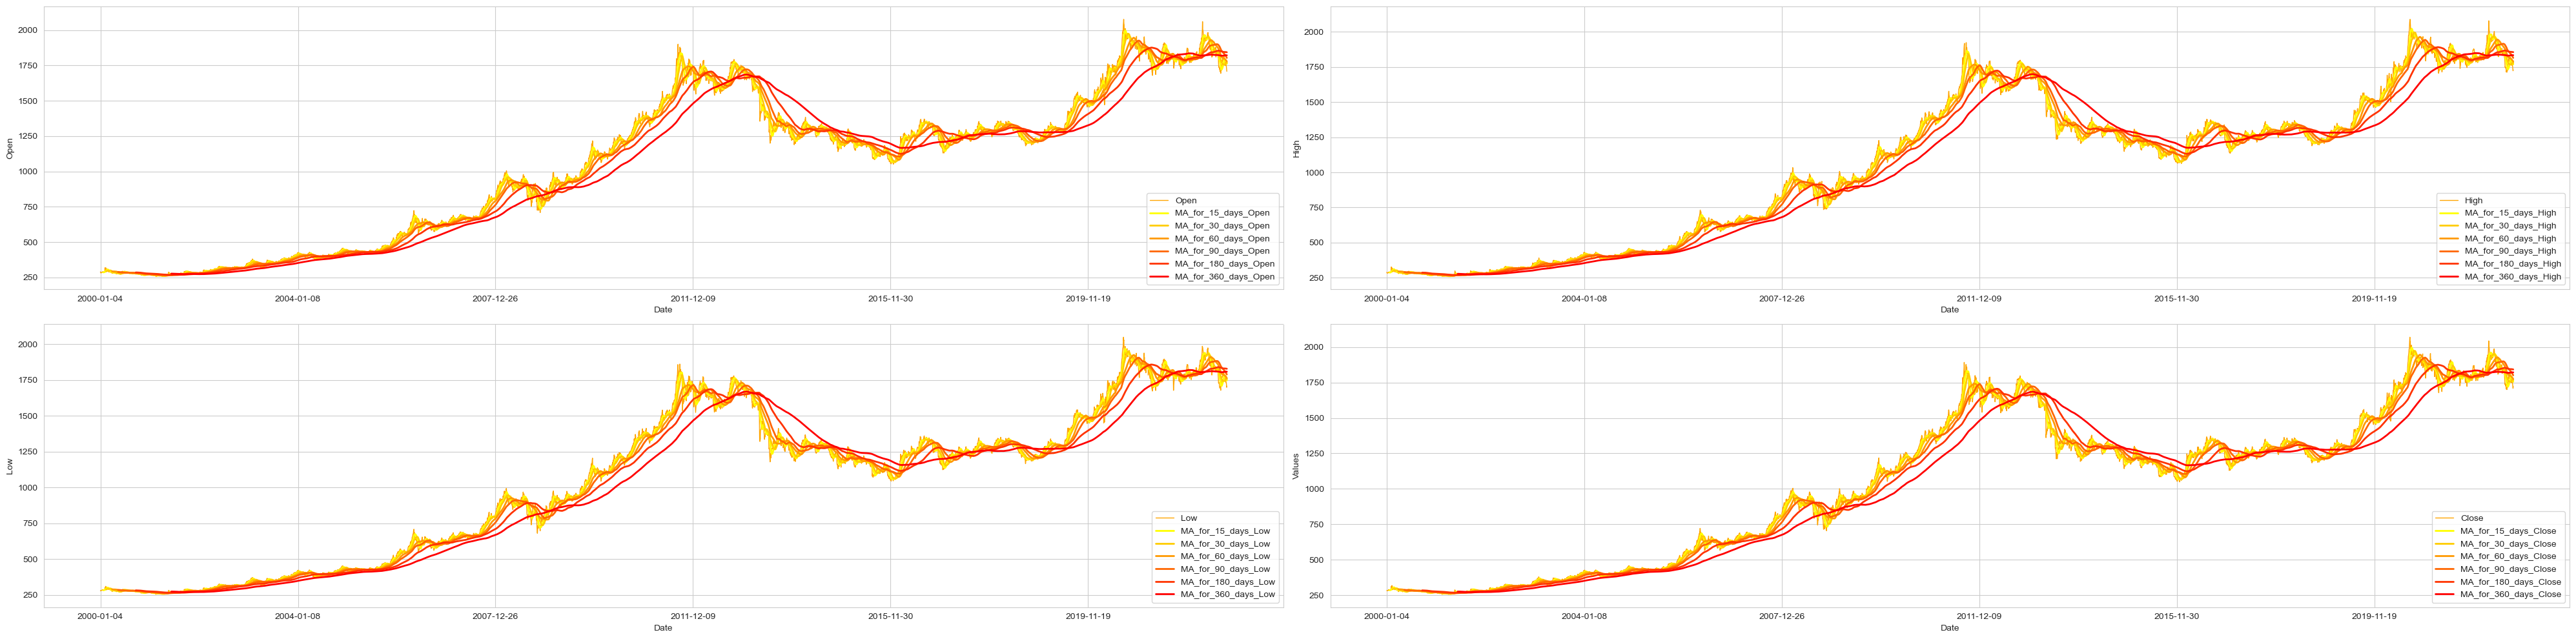

In [15]:
ma_day = [15, 30, 60, 90, 180, 360]
plot_ma_line(gold_df, gold_df.columns[1:-1], "Date", ma_day) #  gold_df.columns[1:-1],

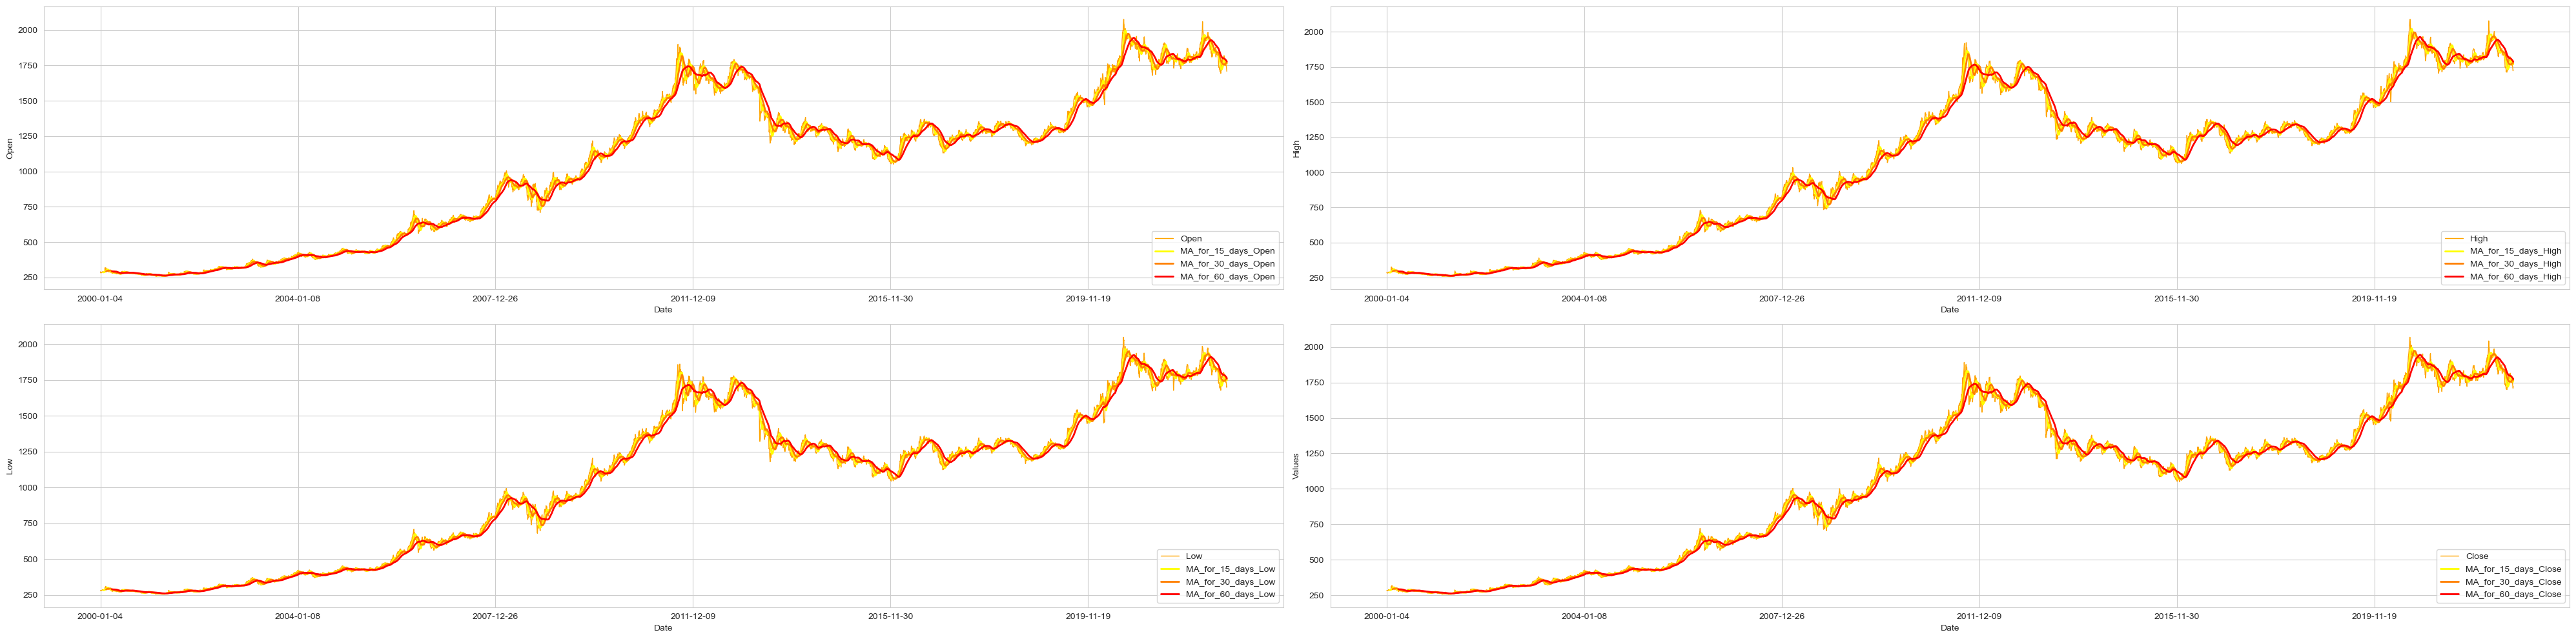

In [16]:
ma_day = [15, 30, 60]
plot_ma_line(gold_df, gold_df.columns[1:-1], "Date", ma_day) #  gold_df.columns[1:-1],

<div class="alert alert-danger" style="background-color: ; color:black;" role="alert ">
  Result : 60 day is selected
</div>

In [17]:
column_name = f"MA_for_{60}_days"
column_name = column_name+"_Close"
gold_df[column_name] = gold_df["Close"].rolling(60).mean()

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 50%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Plot Daily Return</h2>
</div>

In [18]:
def plot_daily_return(df, close_feature_name, date_feature_name):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Daily_Return'] = df['Close'].pct_change()
    average_daily_return = df['Daily_Return'].mean()
    print("Avarage Daily Return : ", average_daily_return)
    plt.figure(figsize=(15, 8))
    df.set_index(date_feature_name)['Daily_Return'].plot(color="orange", label=close_feature_name, lw=1.5,
                                                        linestyle='--', marker='o')
    plt.ylabel('Values')
    plt.xlabel('Date')
    plt.legend(loc='upper right')
    plt.show()
    return average_daily_return

Avarage Daily Return :  0.00037711995193805684


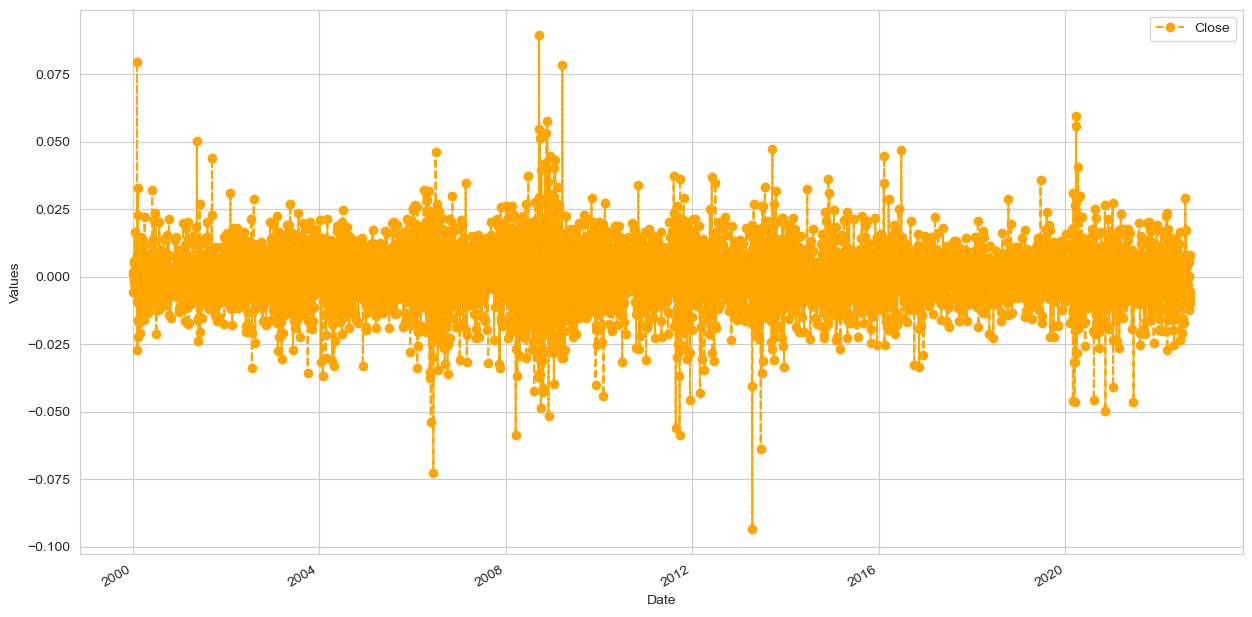

0.00037711995193805684

In [19]:
plot_daily_return(gold_df, 'Close', 'Date')

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 50%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Histogram Daily Return</h2>
</div>

In [20]:
def plot_hist(df, feature_name):
    plt.figure(figsize=(15, 5))
    df[feature_name].hist(bins=50)
    plt.xlabel(feature_name)
    plt.ylabel('Counts')
    plt.ylim()
    plt.title(f'Gold')    
    plt.tight_layout()

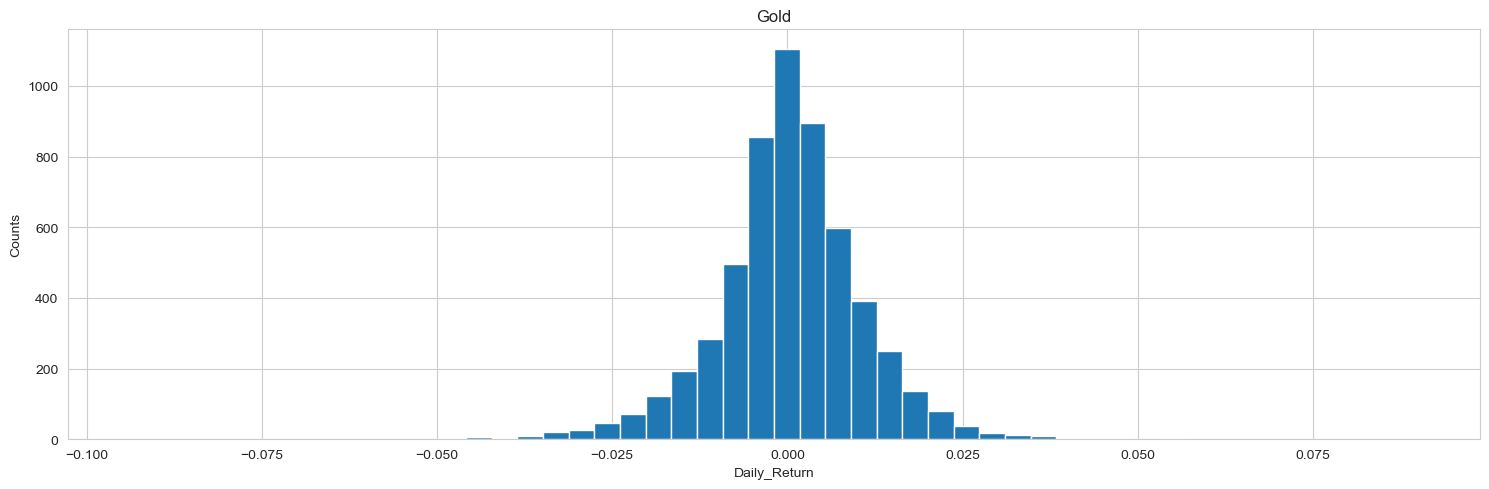

In [21]:
plot_hist(gold_df, 'Daily_Return')

In [22]:
print(f"Expected return: {gold_df['Daily_Return'].mean()} \nRisk: {gold_df['Daily_Return'].std()}")

Expected return: 0.00037711995193805684 
Risk: 0.011013790588068487


<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 50%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Feature Engineering</h2>
</div>

In [23]:
!pip install yfinance -q

In [24]:
# !pip install TA-Lib

In [25]:
import yfinance as yf
import talib as ta

def create_RSI_MACD_BB(df):
    # RSI hesaplama
    # '14' periyot için RSI
    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)
    # MACD hesaplama
    # MACD, Signal line ve Histogram için periyotlar
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    # Bollinger Bands hesaplama
    # '20' periyot ve '2' standart sapma ile Bollinger Bands hesaplama
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    # Sonuçları gösterme
    print(df[['Close', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'BB_upper', 'BB_middle', 'BB_lower']].tail())

In [26]:
create_RSI_MACD_BB(gold_df)

       Close        RSI       MACD  MACD_signal  MACD_hist     BB_upper  \
5698  1749.7  41.910418  -4.880511    -0.432793  -4.447718  1827.653465   
5699  1736.3  38.147653  -6.929037    -1.732042  -5.196996  1829.224546   
5700  1726.2  35.556431  -9.260743    -3.237782  -6.022961  1832.100689   
5701  1709.3  31.678888 -12.330190    -5.056264  -7.273927  1833.087353   
5702  1723.0  37.617935 -13.501636    -6.745338  -6.756298  1832.784484   

      BB_middle     BB_lower  
5698   1782.935  1738.216535  
5699   1780.265  1731.305454  
5700   1777.755  1723.409311  
5701   1772.875  1712.662647  
5702   1769.465  1706.145516  


<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 50%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Impute Nan Values</h2>
</div>

In [27]:
def find_test_size(df, year):# gold_df
    test_size = df[df.Date.dt.year>=year].shape[0]
    print(f"test size: {test_size}")
    return test_size

In [28]:
class Visualization:
    def __init__(self, model= None, history= None, X_train= None, y_train= None, X_test= None, y_test= None):
        self.model = model
        self.history = history
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    def update(self, model, history, X_train, y_train, X_test, y_test):
        if model is not None:
            self.model = model
        if history is not None:
            self.history = history
        if X_train is not None:
            self.X_train = X_train
        if y_train is not None:
            self.y_train = y_train
        if X_test is not None:
            self.X_test = X_test
        if y_test is not None:
            self.y_test = y_test
    def plot_history(self, history): # helper
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(train_loss, label='Train Loss')
        plt.plot(val_loss, label='Test Loss')
        plt.title('Train and Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Kayıp')
        plt.legend()
        plt.show()
    def print_prediction_result(self, model, X, y):
        result = model.evaluate(X, y)
        y_pred = model.predict(X)
        MAPE = mean_squared_error(y, y_pred)
        Accuracy = 1 - MAPE
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        print("Loss:", np.round(result, 10))
        print("MAPE:", np.round(MAPE, 10))
        print("Accuracy:", Accuracy)
        print(f"RMSE: {rmse}")
        return y, y_pred
    def print_result(self):
        print("Train Result")
        self.print_prediction_result(self.model, self.X_train, self.y_train)
        print("=*"*50)
        print("Test Result")
        y_test, y_pred = self.print_prediction_result(self.model, self.X_test, self.y_test)
        return y_test, y_pred

In [29]:
class ImputeClass:
    def __init__(self, df:pd.DataFrame, window_size_lst:list, visualization_obj, test_size):
        self.will_be_imputed = df.columns[df.isnull().any()].tolist()
        self.df = df
        self.test_size = test_size
        self.window_size_lst = window_size_lst
        self.missing_count = 0
        self.visualization = visualization_obj
    # All below 4 functions are helper functions
    def find_feature_index(self, df, feature_name):
        for ind, i in enumerate(df.columns):
            if(i == feature_name):
                return ind
        return -1
    def start_impute_last_index(self, scaled_df, target_column_index):
        model_will_impute = scaled_df[scaled_df.iloc[:,target_column_index].isnull()].iloc[:, target_column_index]
        return model_will_impute.index[-1]    
    def define_model(self, early_stopping, X_train, y_train, X_test, y_test, window_size_=100): # helper
        model=Sequential()
        model.add(LSTM(32,return_sequences=True,input_shape=(window_size_,1)))
        model.add(LSTM(64,return_sequences=True))
        model.add(LSTM(32))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer='adam')
        print(model.summary())
        history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])
        return model, history

    def run_model(self, X_train, y_train, X_test, y_test, window_size): # helper
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        print(f"window_size: {window_size}")
        model, history = self.define_model(early_stopping, X_train, y_train, X_test, y_test, window_size)
        model.save('lstm_model_'+str(self.missing_count)+'.h5')
        self.missing_count += 1
        self.visualization.plot_history(history)
        return model, history
    def scale_df_fun(self): # gold_df
        scaler = MinMaxScaler()
        scaled_gold_df = scaler.fit_transform(self.df.iloc[: ,1:])
        scaled_df = pd.DataFrame(data=scaled_gold_df, columns=self.df.columns[1:])
        return scaled_df
    def impute_column(self, df, model, missing_value_count, window_size, feature_name): # helper
        for i in range(0, missing_value_count+1):
            impute_set = df[feature_name][(window_size-i):2*window_size-i].values[::-1]
            impute_set = impute_set.reshape(1,-1,1)
            result = model.predict(impute_set)
            print(result)
            df[feature_name].loc[(window_size-1)-i]=result[0][0]
        return df
    def train_test_split(self, scaled_df, target_feature_name, window_size):
        feature_index = self.find_feature_index(scaled_df, target_feature_name)
        if(feature_index == -1):
            raise ValueError("feature_index can not be -1, Column must be deleted.")
        train_data = scaled_df[target_feature_name][:-self.test_size]
        train_data = train_data[(self.start_impute_last_index(scaled_df, feature_index))+1:].values[::-1].reshape(-1,1)
        X_train = []
        y_train = []
        for i in range(window_size, len(train_data)):
            X_train.append(train_data[i-window_size:i, 0])
            y_train.append(train_data[i, 0])
        test_data = scaled_df[target_feature_name][-(self.test_size+window_size):]
        test_data = test_data.values[::-1].reshape(-1,1)
        X_test = []
        y_test = []
        for i in range(window_size, len(test_data)):
            X_test.append(test_data[i-window_size:i, 0])
            y_test.append(test_data[i, 0])
        # convert array
        X_train = np.array(X_train)
        X_test  = np.array(X_test)
        y_train = np.array(y_train)
        y_test  = np.array(y_test)
        # reshape
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        y_train = np.reshape(y_train, (-1,1))
        y_test  = np.reshape(y_test, (-1,1))
        # print info
        print('X_train Shape: ', X_train.shape)
        print('y_train Shape: ', y_train.shape)
        print('X_test Shape:  ', X_test.shape)
        print('y_test Shape:  ', y_test.shape)
        return X_train, y_train, X_test, y_test
   
    def run_all(self, window_size_lst:list): # main function
        scaled_df = self.scale_df_fun()
        for ind, target_feature_name in enumerate(self.will_be_imputed):
            window_size = window_size_lst[ind]
            X_train, y_train, X_test, y_test = self.train_test_split(scaled_df, target_feature_name, window_size)
            model, history = self.run_model(X_train, y_train, X_test, y_test, window_size)
            self.visualization.update(model, history, X_train, y_train, X_test, y_test)
            self.visualization.print_result()
            missing_value_count =  scaled_df[target_feature_name].isnull().sum()
            scaled_df = self.impute_column(scaled_df, model, missing_value_count, window_size, target_feature_name)
        return scaled_df

window_size_lst : [59, 1, 14, 33, 33, 33, 19, 19, 19]
test size: 1177
X_train Shape:  (4408, 59, 1)
y_train Shape:  (4408, 1)
X_test Shape:   (1177, 59, 1)
y_test Shape:   (1177, 1)
window_size: 59
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 59, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 59, 64)            24832     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 41,633
Trainable params: 41,633
Non-trainable params: 0
____________________________________________________

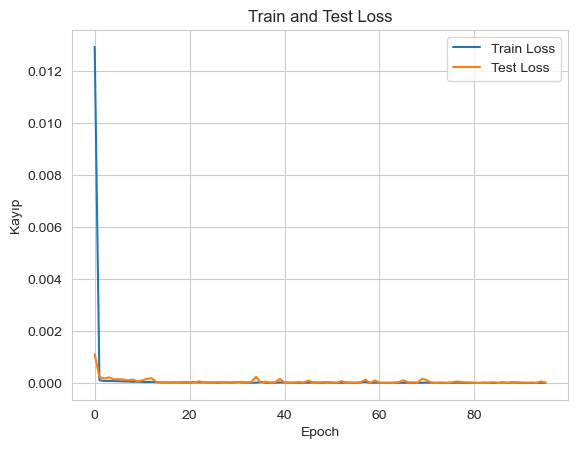

Train Result
138/138 [==============================] - 2s 12ms/step
Loss: 3.4768e-06
MAPE: 3.4768e-06
Accuracy: 0.9999965232122141
RMSE: 0.0018646146481091001
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 12ms/step
Loss: 5.0977e-06
MAPE: 5.0977e-06
Accuracy: 0.9999949022959885
RMSE: 0.0022578095604992056
1/1 [==============================] - 0s 22ms/step
[[0.01751459]]
1/1 [==============================] - 0s 21ms/step
[[0.01750404]]
1/1 [==============================] - 0s 26ms/step
[[0.0174945]]
1/1 [==============================] - 0s 22ms/step
[[0.01748542]]
1/1 [==============================] - 0s 20ms/step
[[0.01747637]]
1/1 [==============================] - 0s 26ms/step
[[0.01746714]]
1/1 [==============================] - 0s 22ms/step
[[0.01745762]]
1/1 [==============================] - 0s 21ms/step
[[0.01744783]]
1/1 [==============================] - 0s 23ms/

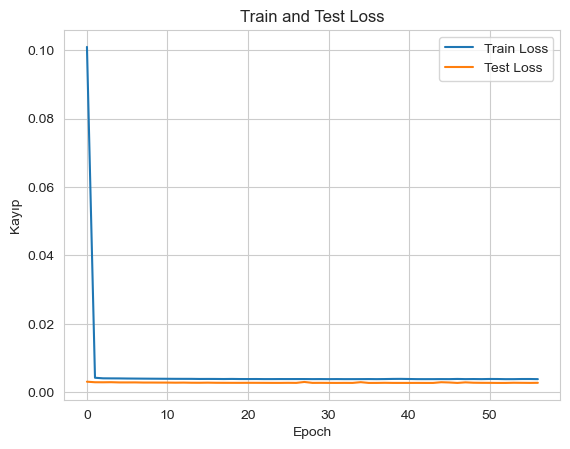

Train Result
142/142 [==============================] - 1s 5ms/step
Loss: 0.0038394236
MAPE: 0.0038394244
Accuracy: 0.9961605755535214
RMSE: 0.061963089387784054
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 5ms/step
Loss: 0.0027587756
MAPE: 0.0027587758
Accuracy: 0.9972412241723312
RMSE: 0.05252404999301551
1/1 [==============================] - 0s 21ms/step
[[0.51204383]]
1/1 [==============================] - 0s 24ms/step
[[0.51203007]]
X_train Shape:  (4498, 14, 1)
y_train Shape:  (4498, 1)
X_test Shape:   (1177, 14, 1)
y_test Shape:   (1177, 1)
window_size: 14
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 32)            4352      
                                                                 
 lstm_7 (LSTM)               (N

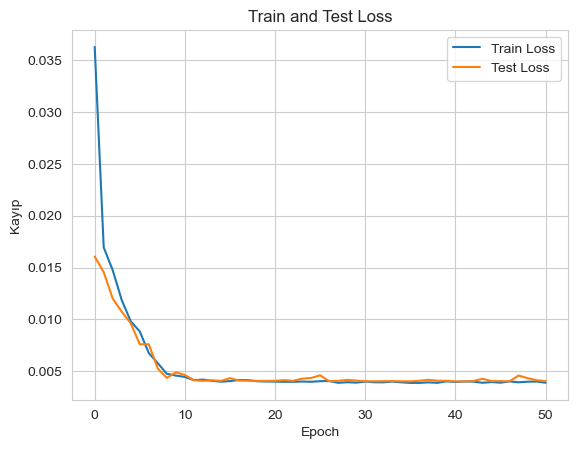

Train Result
141/141 [==============================] - 1s 6ms/step
Loss: 0.0038032883
MAPE: 0.0038032873
Accuracy: 0.9961967126770845
RMSE: 0.06167079797534196
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 6ms/step
Loss: 0.0040270695
MAPE: 0.0040270697
Accuracy: 0.995972930277652
RMSE: 0.0634591973030549
1/1 [==============================] - 0s 19ms/step
[[0.5646269]]
1/1 [==============================] - 0s 19ms/step
[[0.5588984]]
1/1 [==============================] - 0s 23ms/step
[[0.55322176]]
1/1 [==============================] - 0s 20ms/step
[[0.5477222]]
1/1 [==============================] - 0s 21ms/step
[[0.54235643]]
1/1 [==============================] - 0s 19ms/step
[[0.537321]]
1/1 [==============================] - 0s 25ms/step
[[0.5329189]]
1/1 [==============================] - 0s 20ms/step
[[0.52888256]]
1/1 [==============================] - 0s 19ms/step


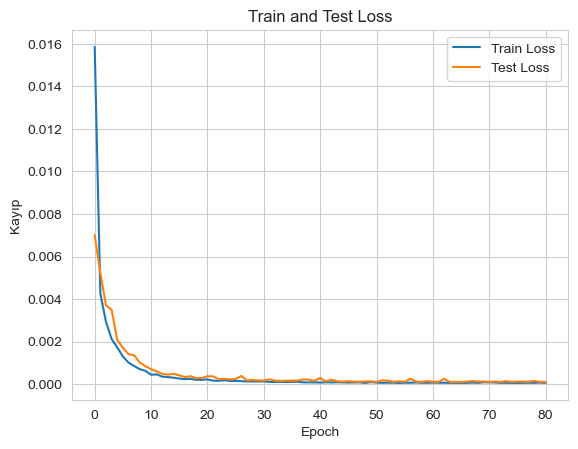

Train Result
140/140 [==============================] - 2s 9ms/step
Loss: 5.73211e-05
MAPE: 5.73211e-05
Accuracy: 0.9999426788767488
RMSE: 0.0075710714731260275
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 10ms/step
Loss: 0.0001120573
MAPE: 0.0001120572
Accuracy: 0.9998879427509044
RMSE: 0.010585709664240646
1/1 [==============================] - 0s 23ms/step
[[0.48840284]]
1/1 [==============================] - 0s 23ms/step
[[0.49031475]]
1/1 [==============================] - 0s 28ms/step
[[0.491353]]
1/1 [==============================] - 0s 26ms/step
[[0.49172345]]
1/1 [==============================] - 0s 22ms/step
[[0.49159855]]
1/1 [==============================] - 0s 22ms/step
[[0.4911183]]
1/1 [==============================] - 0s 24ms/step
[[0.49039862]]
1/1 [==============================] - 0s 21ms/step
[[0.48953277]]
1/1 [==============================] - 0s 21m

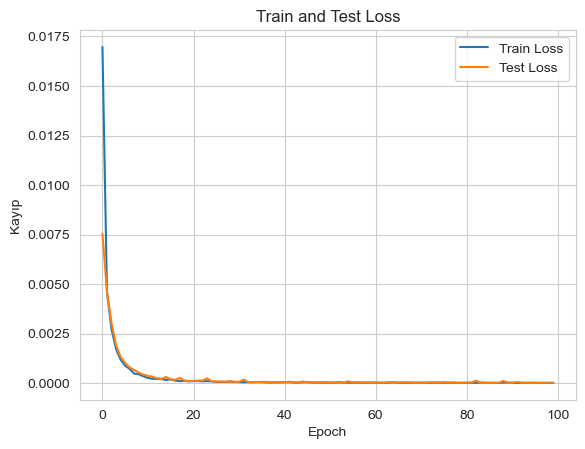

Train Result
140/140 [==============================] - 2s 9ms/step
Loss: 8.4874e-06
MAPE: 8.4874e-06
Accuracy: 0.99999151258831
RMSE: 0.002913316270168876
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 10ms/step
Loss: 1.38621e-05
MAPE: 1.38621e-05
Accuracy: 0.9999861378766053
RMSE: 0.003723187262905818
1/1 [==============================] - 0s 22ms/step
[[0.4894948]]
1/1 [==============================] - 0s 20ms/step
[[0.48583305]]
1/1 [==============================] - 0s 19ms/step
[[0.4791504]]
1/1 [==============================] - 0s 22ms/step
[[0.4698571]]
1/1 [==============================] - 0s 22ms/step
[[0.45813245]]
1/1 [==============================] - 0s 21ms/step
[[0.4442971]]
1/1 [==============================] - 0s 20ms/step
[[0.42866513]]
1/1 [==============================] - 0s 22ms/step
[[0.41157317]]
1/1 [==============================] - 0s 23ms/step
[

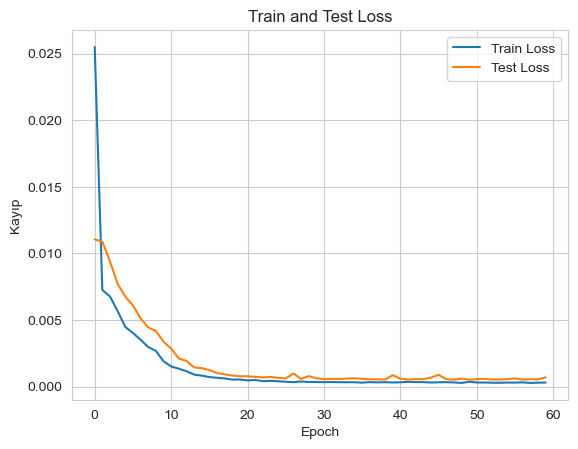

Train Result
140/140 [==============================] - 2s 9ms/step
Loss: 0.0002678458
MAPE: 0.0002678457
Accuracy: 0.9997321543350205
RMSE: 0.016365991108988304
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 8ms/step
Loss: 0.0005178502
MAPE: 0.0005178502
Accuracy: 0.999482149791996
RMSE: 0.022756322374321136
1/1 [==============================] - 0s 20ms/step
[[0.6381936]]
1/1 [==============================] - 0s 19ms/step
[[0.64670604]]
1/1 [==============================] - 0s 20ms/step
[[0.6542635]]
1/1 [==============================] - 0s 18ms/step
[[0.660707]]
1/1 [==============================] - 0s 19ms/step
[[0.6659969]]
1/1 [==============================] - 0s 20ms/step
[[0.67018044]]
1/1 [==============================] - 0s 23ms/step
[[0.6733378]]
1/1 [==============================] - 0s 22ms/step
[[0.6755716]]
1/1 [==============================] - 0s 21ms/ste

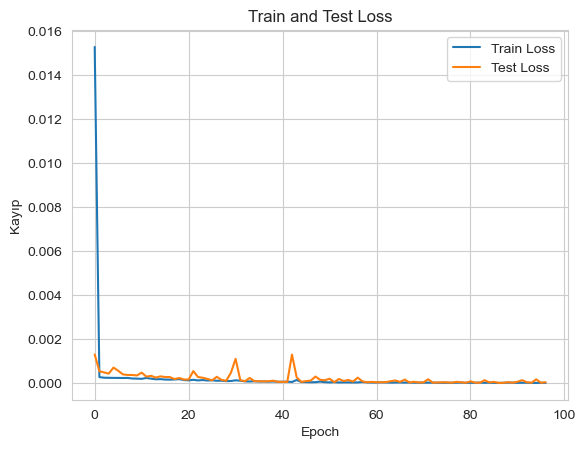

Train Result
141/141 [==============================] - 2s 7ms/step
Loss: 1.10531e-05
MAPE: 1.10531e-05
Accuracy: 0.999988946862688
RMSE: 0.003324625890533163
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 6ms/step
Loss: 1.50871e-05
MAPE: 1.50871e-05
Accuracy: 0.999984912948122
RMSE: 0.003884205437156792
1/1 [==============================] - 0s 19ms/step
[[0.01778762]]
1/1 [==============================] - 0s 21ms/step
[[0.01660899]]
1/1 [==============================] - 0s 21ms/step
[[0.01601294]]
1/1 [==============================] - 0s 22ms/step
[[0.01577894]]
1/1 [==============================] - 0s 18ms/step
[[0.01572117]]
1/1 [==============================] - 0s 19ms/step
[[0.0157261]]
1/1 [==============================] - 0s 19ms/step
[[0.01573988]]
1/1 [==============================] - 0s 20ms/step
[[0.01574128]]
1/1 [==============================] - 0s 21ms/st

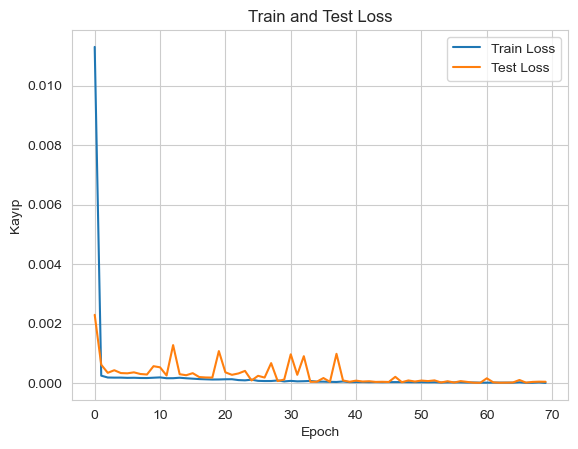

Train Result
141/141 [==============================] - 2s 7ms/step
Loss: 1.4955e-05
MAPE: 1.4955e-05
Accuracy: 0.9999850449829268
RMSE: 0.0038671717149774947
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 7ms/step
Loss: 1.61017e-05
MAPE: 1.61017e-05
Accuracy: 0.9999838982941895
RMSE: 0.0040126930869964815
1/1 [==============================] - 0s 24ms/step
[[0.0158054]]
1/1 [==============================] - 0s 22ms/step
[[0.01522879]]
1/1 [==============================] - 0s 25ms/step
[[0.01476242]]
1/1 [==============================] - 0s 23ms/step
[[0.01439069]]
1/1 [==============================] - 0s 24ms/step
[[0.01408732]]
1/1 [==============================] - 0s 21ms/step
[[0.01382828]]
1/1 [==============================] - 0s 25ms/step
[[0.01359421]]
1/1 [==============================] - 0s 24ms/step
[[0.013373]]
1/1 [==============================] - 0s 26ms/st

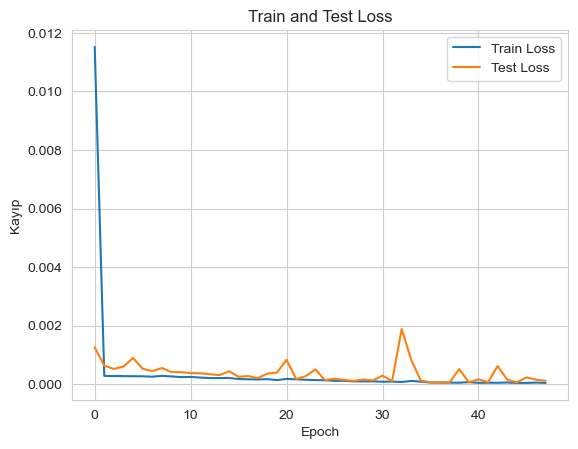

Train Result
141/141 [==============================] - 1s 6ms/step
Loss: 4.52996e-05
MAPE: 4.52996e-05
Accuracy: 0.9999547004161556
RMSE: 0.006730496552587309
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 6ms/step
Loss: 5.98736e-05
MAPE: 5.98736e-05
Accuracy: 0.9999401263884475
RMSE: 0.007737804052344294
1/1 [==============================] - 0s 19ms/step
[[0.01245304]]
1/1 [==============================] - 0s 22ms/step
[[0.01291408]]
1/1 [==============================] - 0s 25ms/step
[[0.01317833]]
1/1 [==============================] - 0s 22ms/step
[[0.01325134]]
1/1 [==============================] - 0s 21ms/step
[[0.01317921]]
1/1 [==============================] - 0s 23ms/step
[[0.01301452]]
1/1 [==============================] - 0s 21ms/step
[[0.01280086]]
1/1 [==============================] - 0s 24ms/step
[[0.01256845]]
1/1 [==============================] - 0s 22ms

In [30]:
window_size_lst = [] 
for i in gold_df.columns[gold_df.isnull().any()].tolist():
    window_size_lst.append(gold_df[i].isnull().sum())
print(f"window_size_lst : {window_size_lst}")
try:
    visualization_obj = Visualization()
    impute_obj = ImputeClass(gold_df, window_size_lst, visualization_obj, test_size = find_test_size(gold_df, 2018))
    filled_df = impute_obj.run_all(window_size_lst)
except ValueError:
    print("Column is not in df anymore.")
except:
    print("Something is wrong.")

In [31]:
gold_df.head(3)

Date   Open   High    Low  Close  Volume  MA_for_60_days_Close  \
0 2000-01-04  289.5  289.5  280.0  283.7   21621                   NaN   
1 2000-01-05  283.7  285.0  281.0  282.1   25448                   NaN   
2 2000-01-06  281.6  282.8  280.2  282.4   19055                   NaN   

   Daily_Return  RSI  MACD  MACD_signal  MACD_hist  BB_upper  BB_middle  \
0           NaN  NaN   NaN          NaN        NaN       NaN        NaN   
1     -0.005640  NaN   NaN          NaN        NaN       NaN        NaN   
2      0.001063  NaN   NaN          NaN        NaN       NaN        NaN   

   BB_lower  
0       NaN  
1       NaN  
2       NaN

In [32]:
filled_df.head(3)

Open      High       Low     Close    Volume  MA_for_60_days_Close  \
0  0.018079  0.016450  0.013880  0.014949  0.026479              0.017119   
1  0.014892  0.013991  0.014438  0.014067  0.031166              0.017124   
2  0.013738  0.012788  0.013992  0.014232  0.023337              0.017128   

   Daily_Return       RSI      MACD  MACD_signal  MACD_hist  BB_upper  \
0      0.512044  0.509182  0.464978     0.280241   0.639822  0.015034   
1      0.479470  0.511987  0.465825     0.268059   0.641562  0.015109   
2      0.516073  0.514977  0.466701     0.255998   0.643480  0.015179   

   BB_middle  BB_lower  
0   0.010974  0.010352  
1   0.011191  0.010552  
2   0.011411  0.010749

In [33]:
filled_df["Date"] = gold_df["Date"]
filled_df = filled_df[[filled_df.columns[-1]] + list(filled_df.columns[:-1])]

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 50%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Plot Imputed Features</h2>
</div>

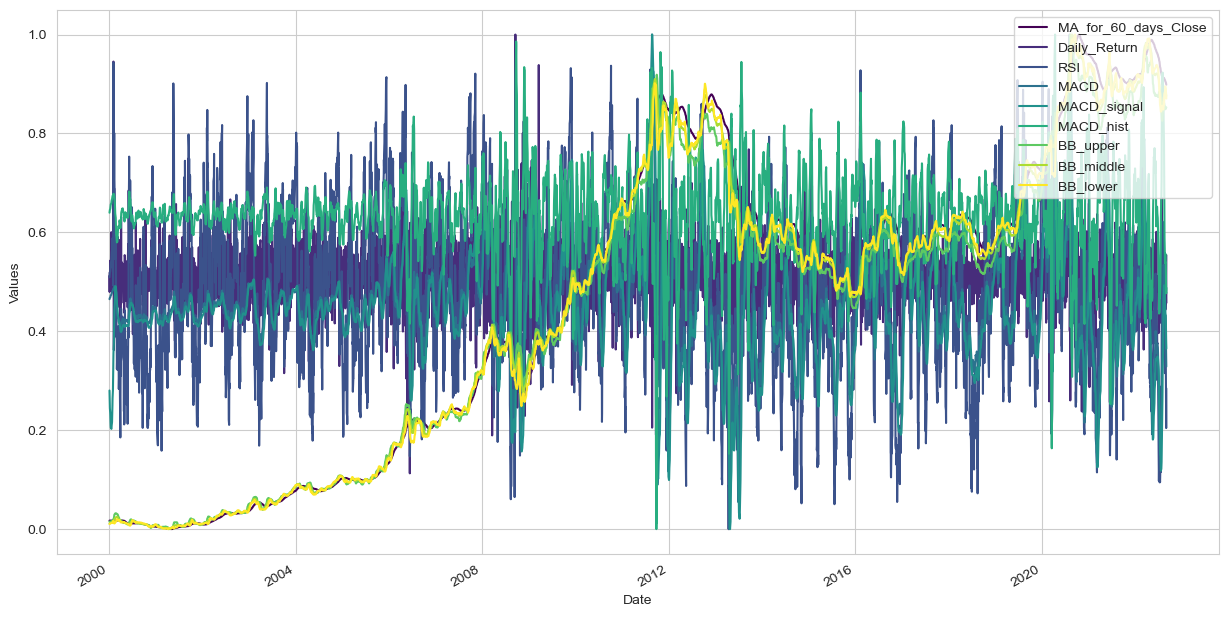

In [34]:
plot_historical_line_one(filled_df, filled_df.columns[6:], "Date")

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 50%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Predict Close Price</h2>
</div>

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 100%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> 1 - Use [MA_for_60_days_Close, Daily_Return, RSI, MACD, MACD_signal, MACD_hist, BB_upper, BB_middle, BB_lower] features to Predict Close Price</h2>
</div>

In [35]:
class ModelLSTM:
    def __init__(self, df, starting_col_ind, target_feature, test_size, visualization_obj):
        self.df = df
        self.starting_col_ind = starting_col_ind
        self.target_feature = target_feature
        self.test_size = test_size
        self.model = None
        self.visualization = visualization_obj
    def create_train_test(self):
        X = self.df.iloc[:,self.starting_col_ind:].values
        y = self.df[self.target_feature]
        X = X.reshape((X.shape[0], X.shape[1], 1)) 
        X_train = X[:-self.test_size]
        y_train = y[:-self.test_size]
        X_test = X[-self.test_size:]
        y_test = y[-self.test_size:]
        return X_train, y_train, X_test, y_test
    def predict_close_LSTM(self, X_train, y_train, X_test, y_test):
        model=Sequential()
        model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        print(model.summary())
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])
        self.model = model
        self.visualization.plot_history(history)
        return history
    def run_all(self):
        X_train, y_train, X_test, y_test = self.create_train_test()
        history = self.predict_close_LSTM(X_train, y_train, X_test, y_test)
        self.visualization.update(self.model, history, X_train, y_train, X_test, y_test)
        y_test, y_pred = self.visualization.print_result()
        return y_test, y_pred

test size: 1177
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 9, 32)             4352      
                                                                 
 lstm_28 (LSTM)              (None, 9, 64)             24832     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 41,633
Trainable params: 41,633
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
71/71 [==============================] - 4s 24ms/step - loss: 0.0519 - val_loss: 0.0321
Epoch 2/100
71/71 [==============================] - 1s 14ms/

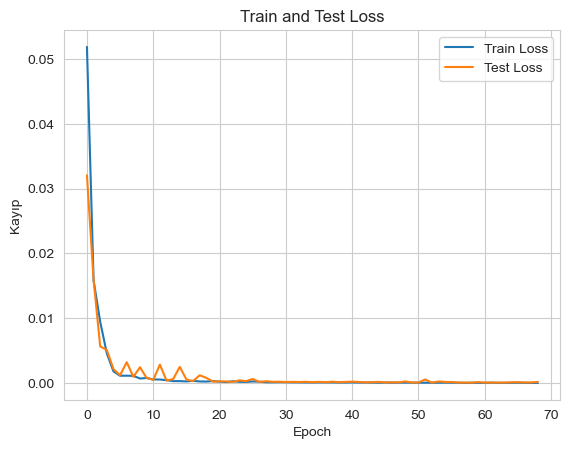

Train Result
142/142 [==============================] - 1s 6ms/step
Loss: 4.23455e-05
MAPE: 4.23455e-05
Accuracy: 0.9999576545262494
RMSE: 0.00650733999039276
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 0s 5ms/step
Loss: 7.09275e-05
MAPE: 7.09275e-05
Accuracy: 0.9999290725289296
RMSE: 0.008421844873325828


In [36]:
test_size = find_test_size(gold_df, 2018)
target_feature_name="Close"
model_obj = ModelLSTM(filled_df, 6, target_feature_name, test_size, visualization_obj)
y_test, y_pred = model_obj.run_all()

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> 1 - Plot First Approach Result</h2>
</div>

In [37]:
def plot_prediction(df, test_size, date_feature_name, target_feature_name, y_test, y_pred, scaler):
    y_test_true = scaler.inverse_transform(y_test)
    y_test_pred = scaler.inverse_transform(y_pred)
    train = scaler.inverse_transform(df[target_feature_name].values.reshape(-1,1))
    plt.figure(figsize=(15, 6), dpi=150)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rc('axes',edgecolor='blue')
    plt.plot(df[date_feature_name][:-test_size].values, train[:-test_size], color='orange', lw=2) 
    plt.plot(df[date_feature_name][-test_size:].values, y_test_true.reshape(-1), color='red', lw=2)
    plt.plot(df[date_feature_name][-test_size:].values, y_test_pred.reshape(-1), color='yellow', lw=2)
    plt.title('Model Performance on Gold Price Prediction', fontsize=15)
    plt.xlabel(date_feature_name, fontsize=12)
    plt.ylabel(target_feature_name, fontsize=12)
    plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
    plt.grid(color='gray')
    plt.show()

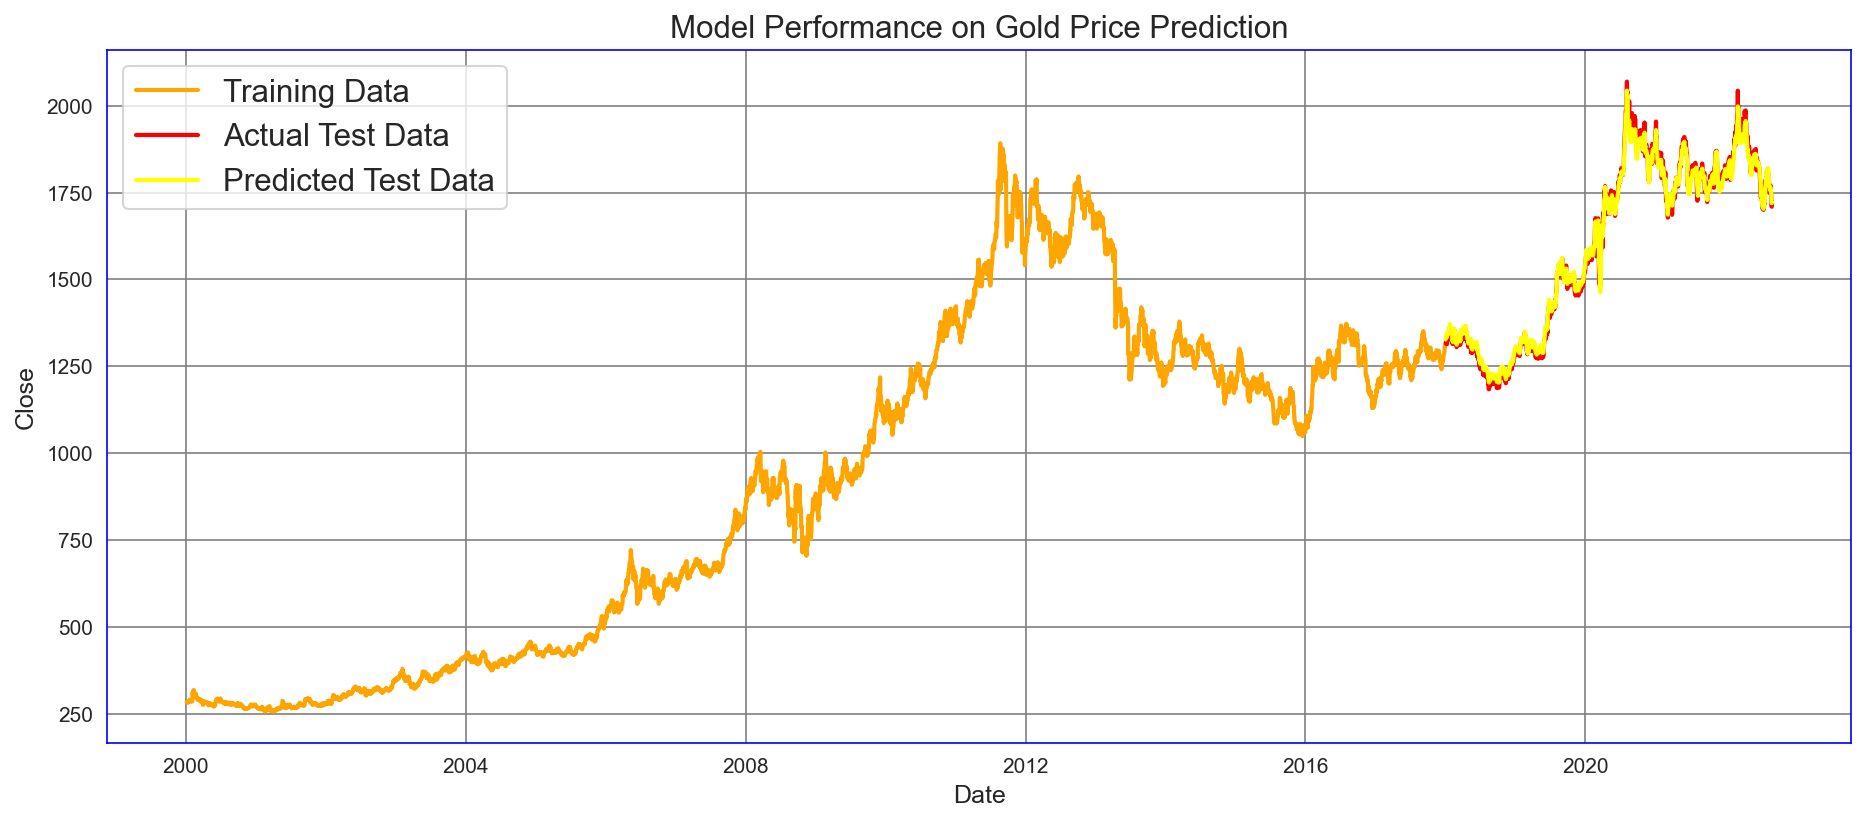

In [38]:
date_feature_name="Date"
target_feature_name="Close"
scaler = MinMaxScaler()
scaler.fit_transform(gold_df[[target_feature_name]].values.reshape(-1,1))
visualization_df = pd.concat([filled_df[[date_feature_name, target_feature_name]], filled_df.iloc[:,6:]], axis=1)

plot_prediction(visualization_df, model_obj.test_size, date_feature_name, target_feature_name, y_test.values.reshape(-1,1), y_pred, scaler)

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 100%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> 2 - LSTM Result Using Only Close feature to Predict Close Price</h2>
</div>

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> Visualize Train and Test Dataset on Line Chart</h2>
</div>

In [39]:
def plot_train_test(df, test_size, date_feature_name, target_feature_name):
    plt.figure(figsize=(15, 6), dpi=150)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rc('axes',edgecolor='yellow')
    plt.plot(df[date_feature_name][:-test_size].values, df[target_feature_name][:-test_size].values, color='#d35400', lw=2)
    plt.plot(df[date_feature_name][-test_size:].values, df[target_feature_name][-test_size:].values, color='#f4d03f', lw=2)
    plt.title('Gold Price Training and Test Sets', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close', fontsize=12)
    plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
    plt.grid(color='pink')
    plt.show()

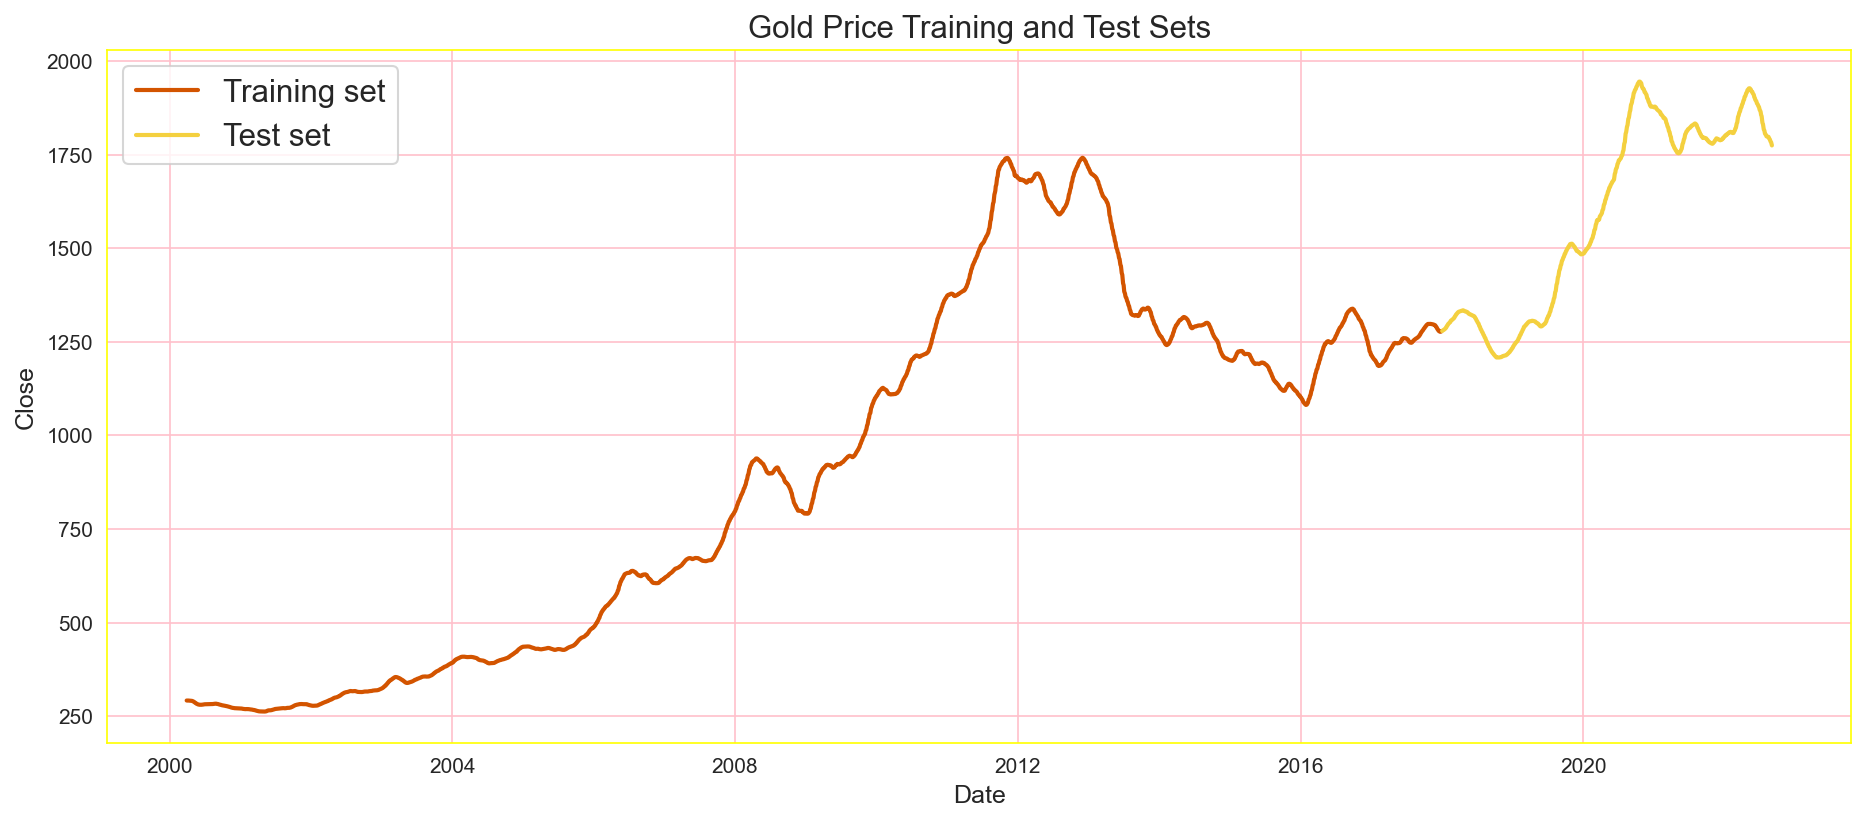

In [40]:
plot_train_test(gold_df, test_size, "Date", "MA_for_60_days_Close")

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> Select Window Size for Sliding Window Approach</h2>
</div>

In [41]:
def plot_train_test_window(df, test_size, date_feature_name, target_feature_name):
    window_size = [30, 50, 100, 200, 300, 400, 500]
    for i in window_size:
        plt.figure(figsize=(30, 6), dpi=150)
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rc('axes',edgecolor='yellow')
        counter=0
        train_color = ["green", "red"]
        test_color = ["purple", "blue"]
        for j in range(0, len(df)-1, i):
            plt.plot(df[date_feature_name][:-test_size][j:j+i].values, df[target_feature_name][:-test_size][j:j+i].values, color=train_color[counter%2], lw=2)
            plt.plot(df[date_feature_name][-test_size:][j:j+i].values, df[target_feature_name][-test_size:][j:j+i].values, color=test_color[counter%2], lw=2)
            counter += 1
            
        plt.title(f'Gold Price Training and Test Sets Window Size = {i}', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Close', fontsize=12)
        plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
        # Grid ekleme (her 100. veri noktasında grid çizgisi olacak şekilde)
        plt.grid(True, which='both', axis='x', linestyle='--', color='gray', linewidth=0.5)
        plt.show()

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> Sliding Window Approach on Raw Data</h2>
</div>

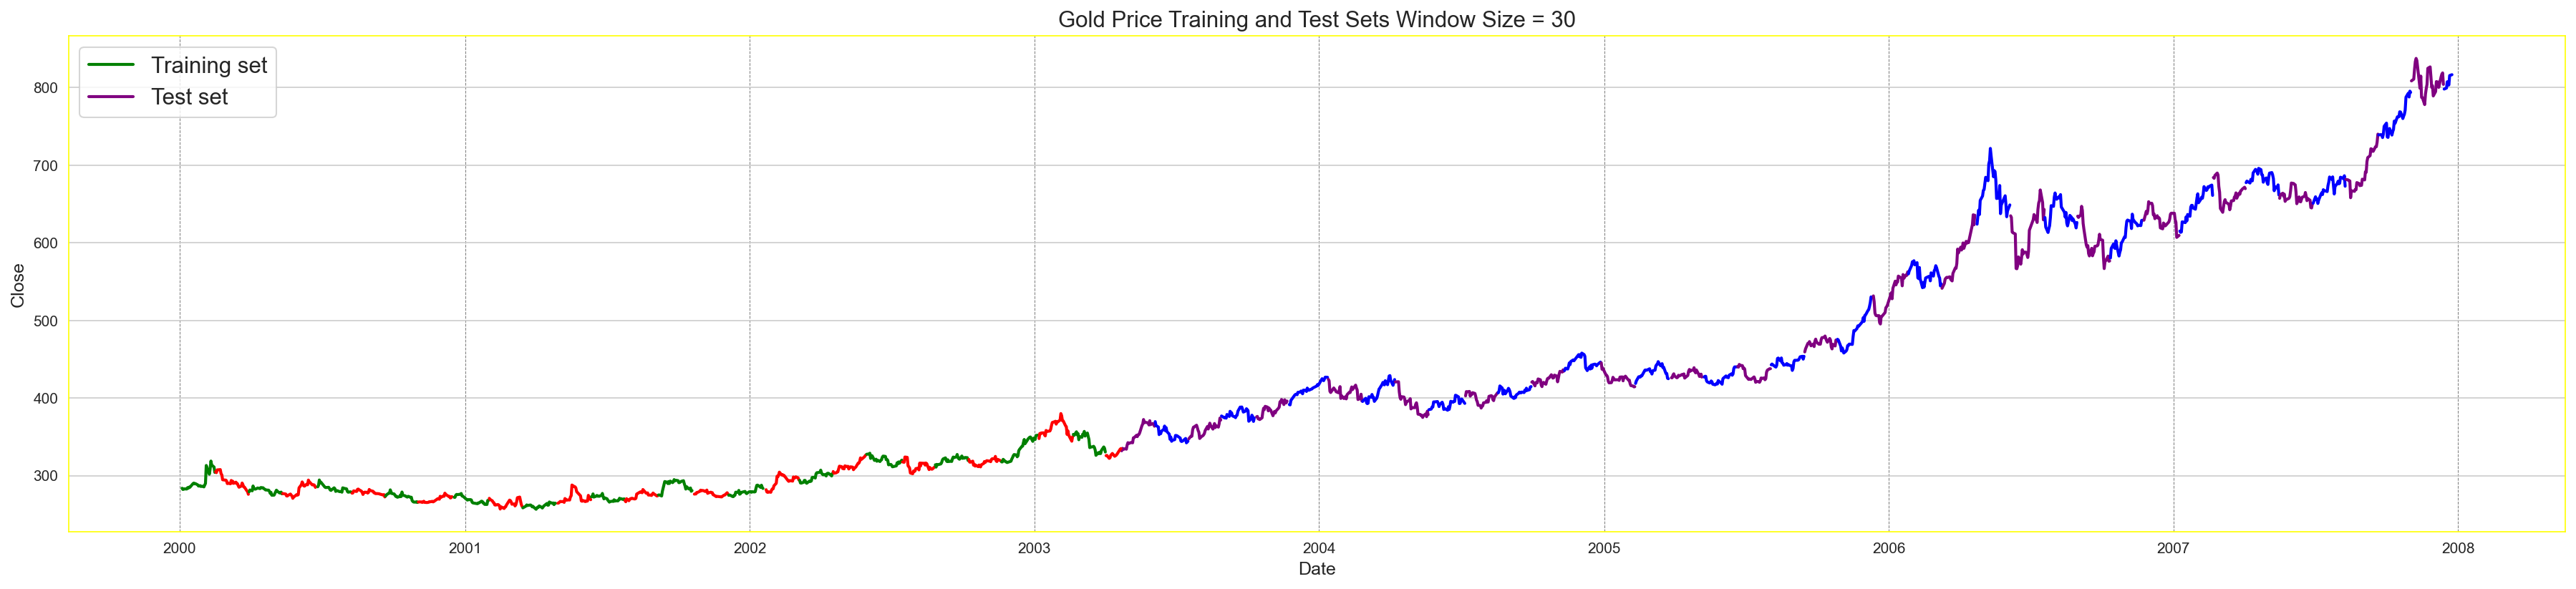

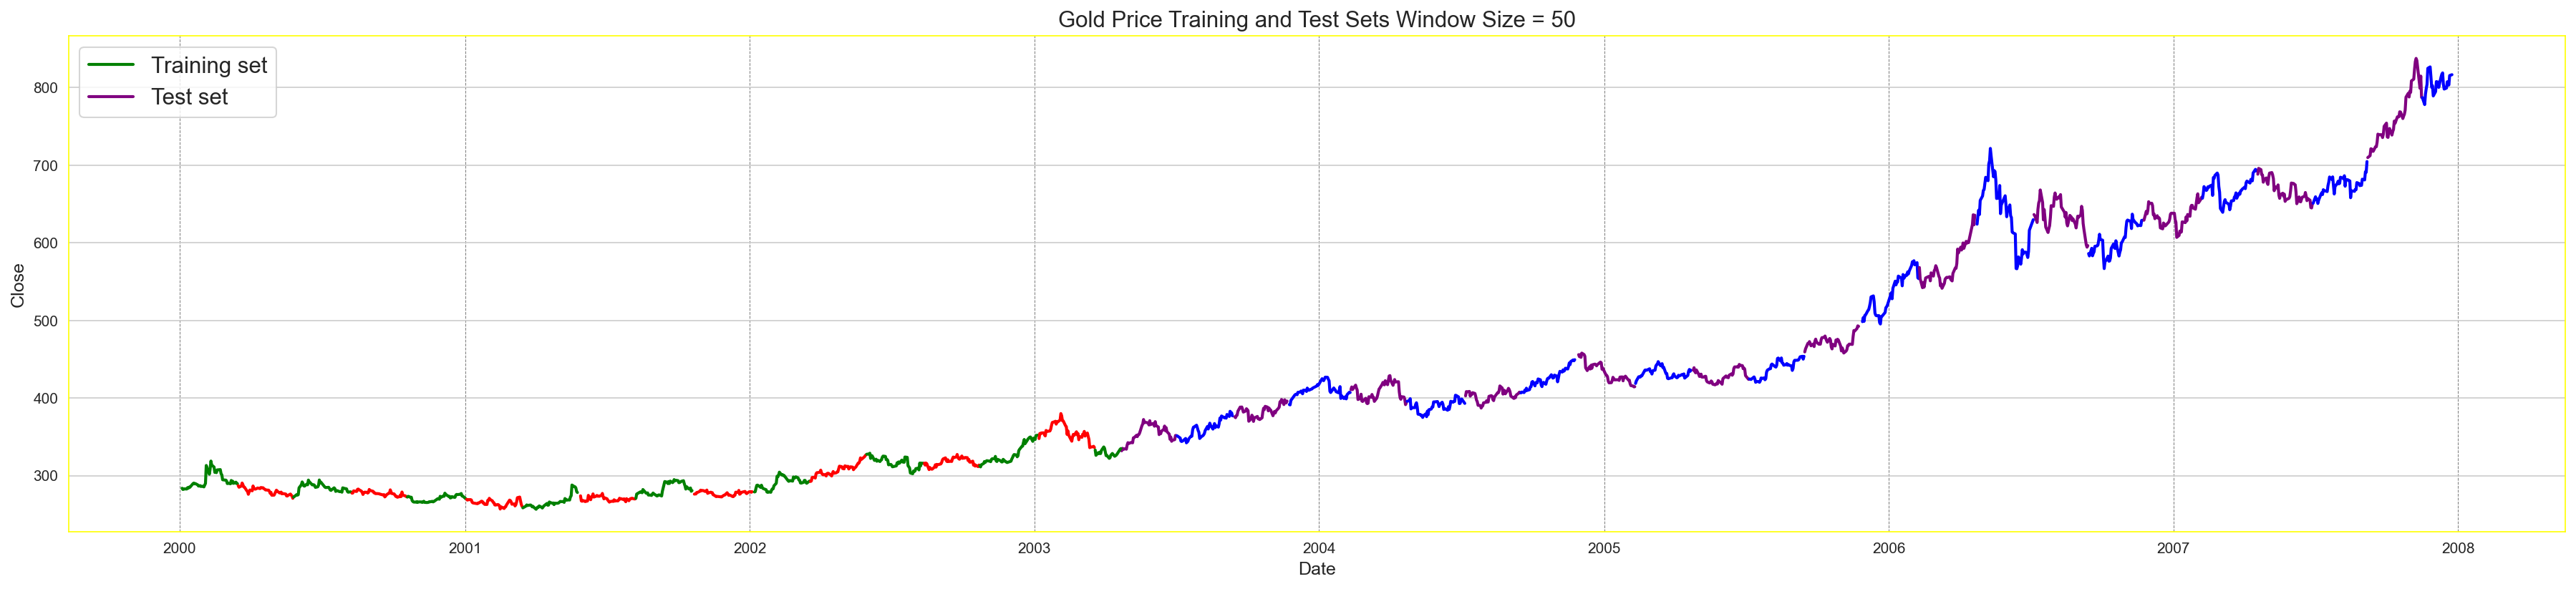

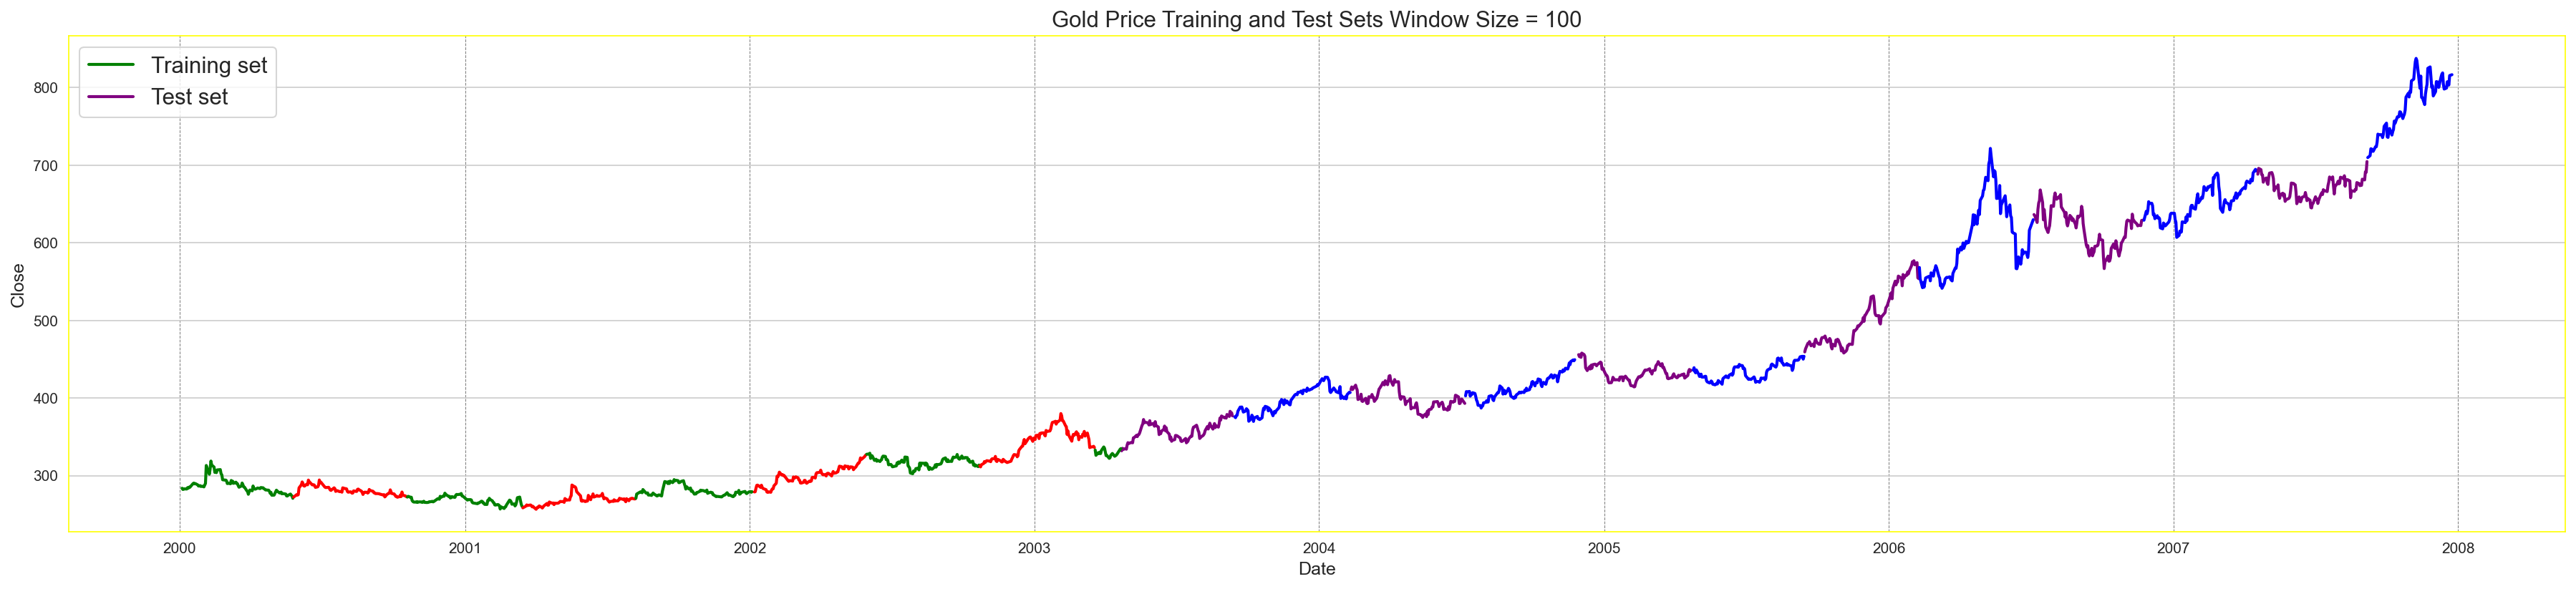

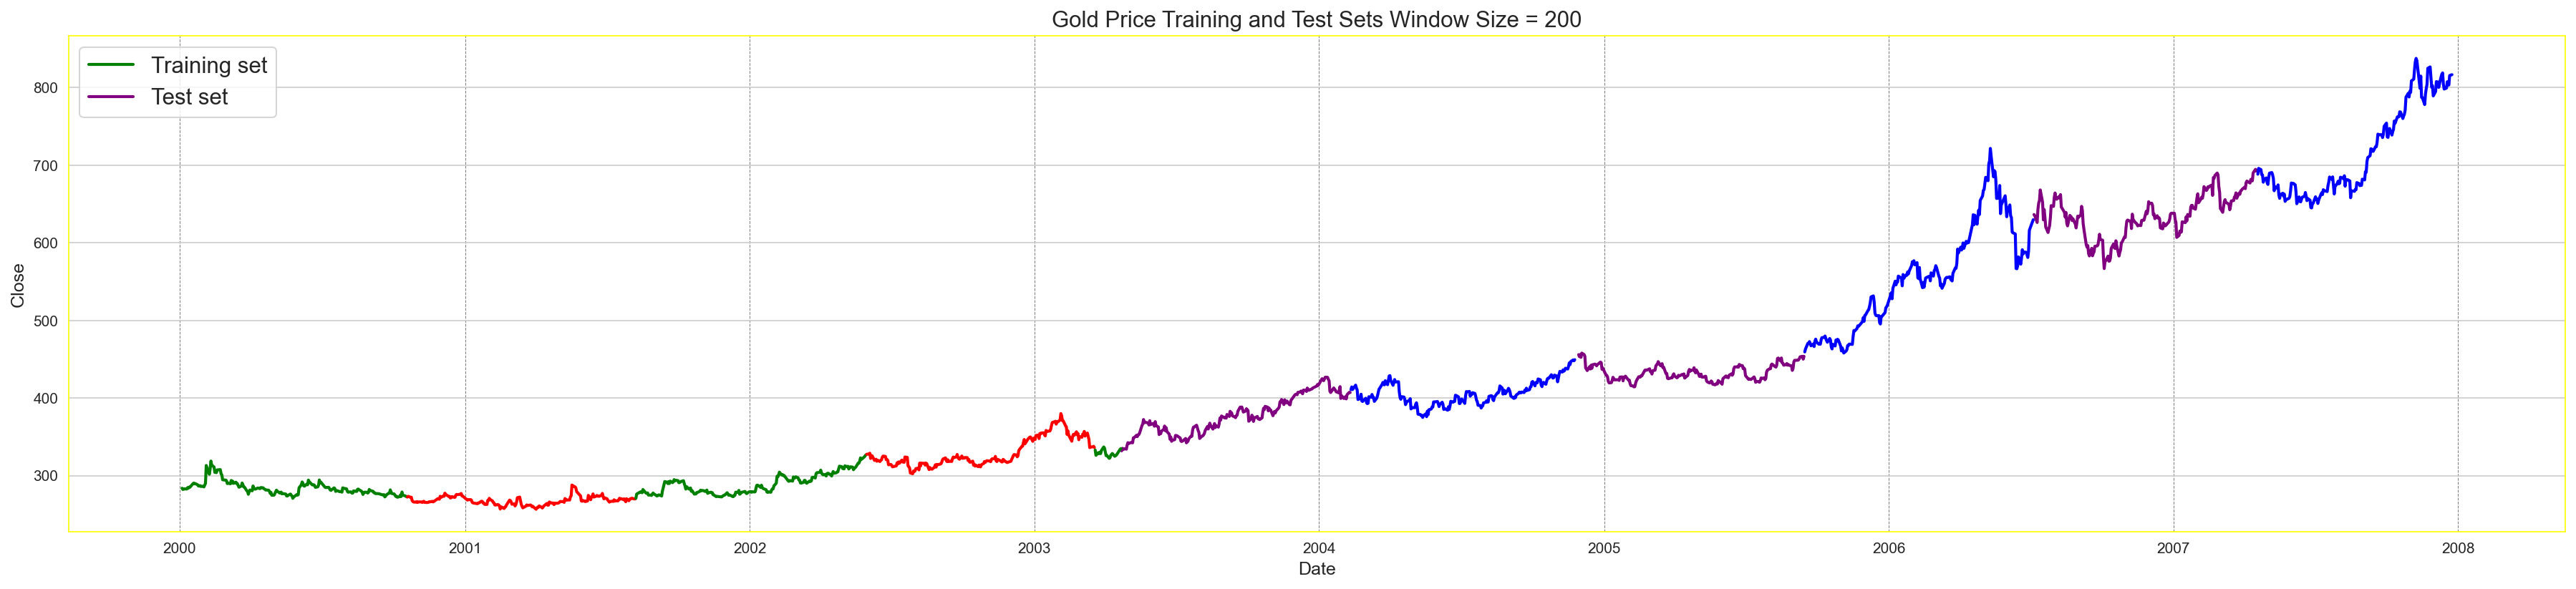

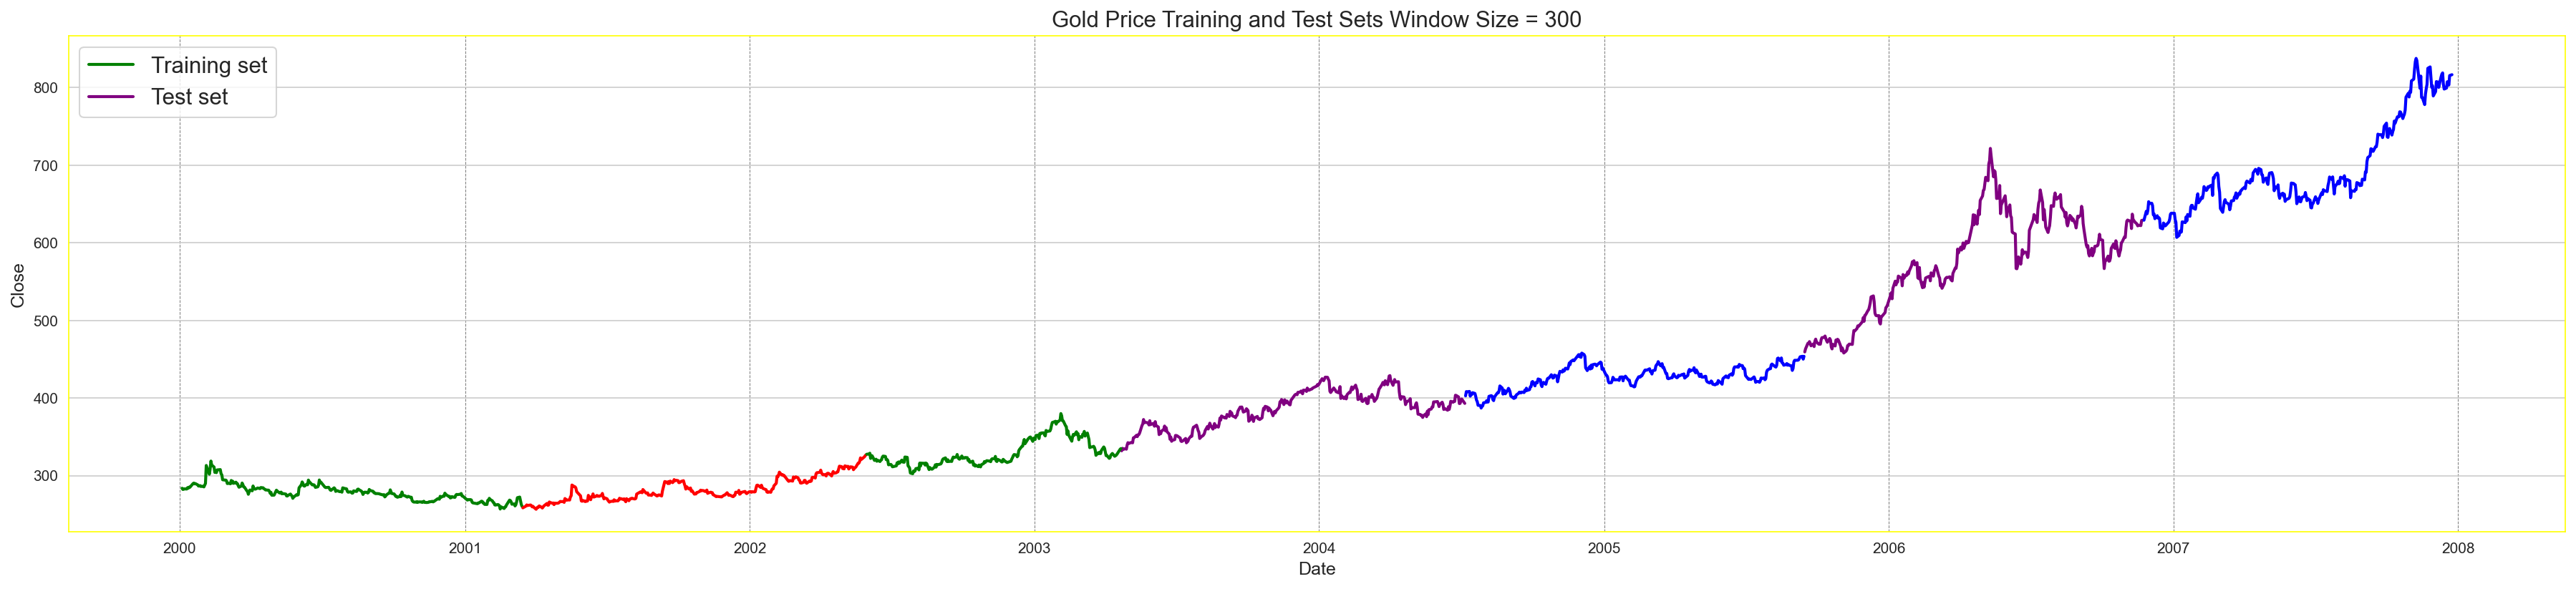

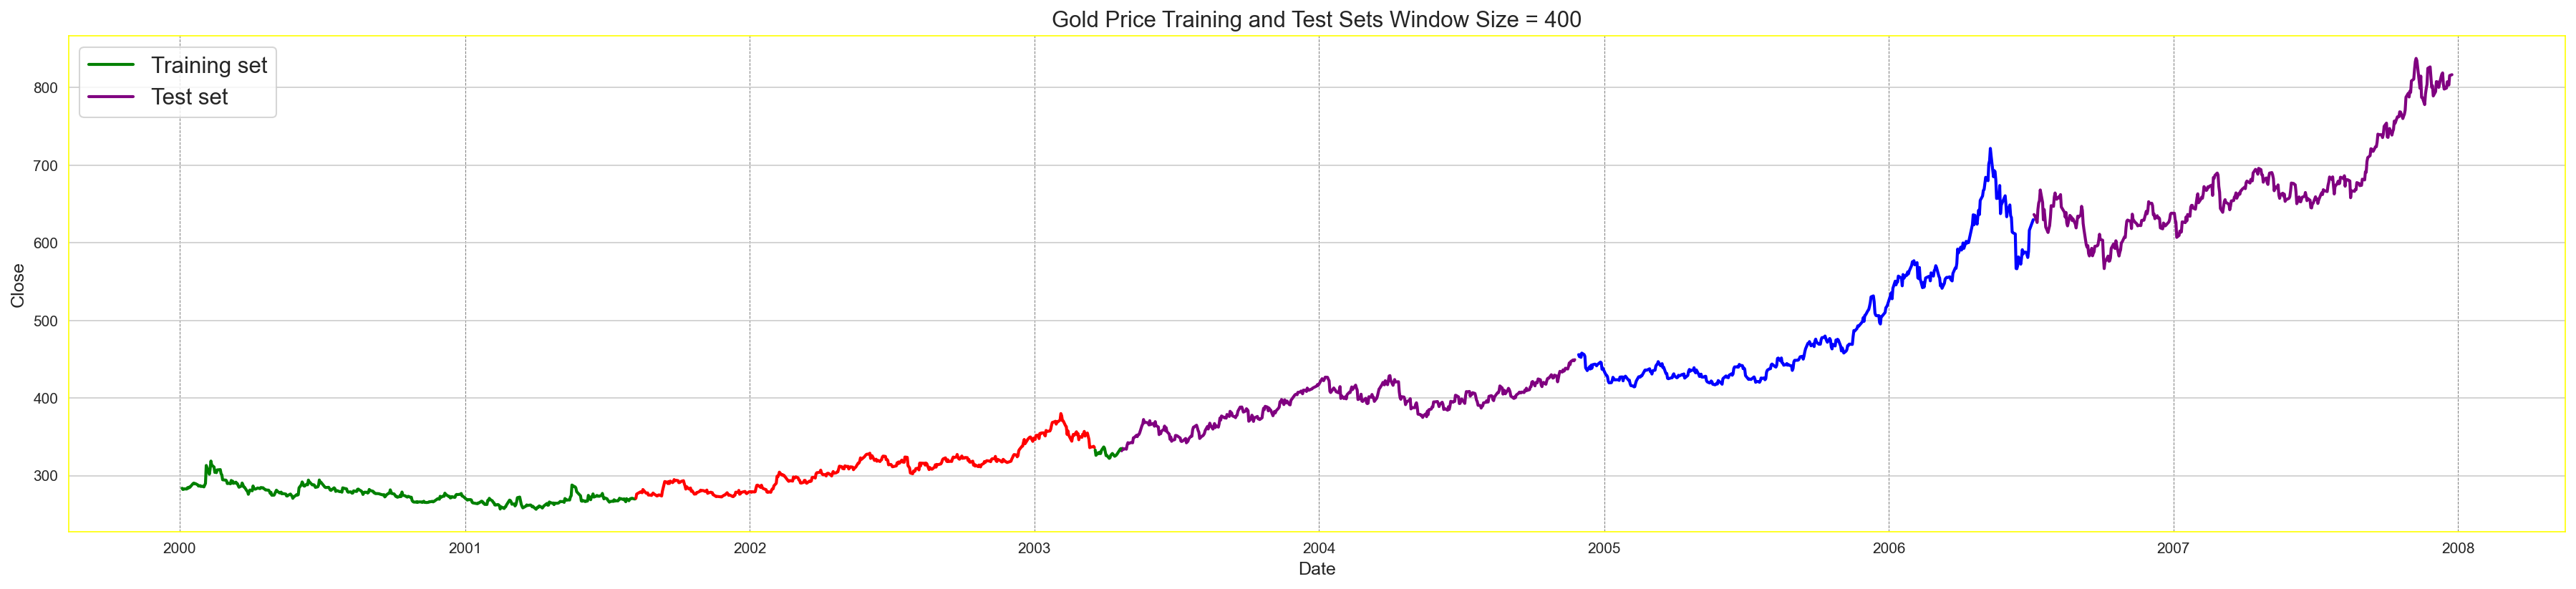

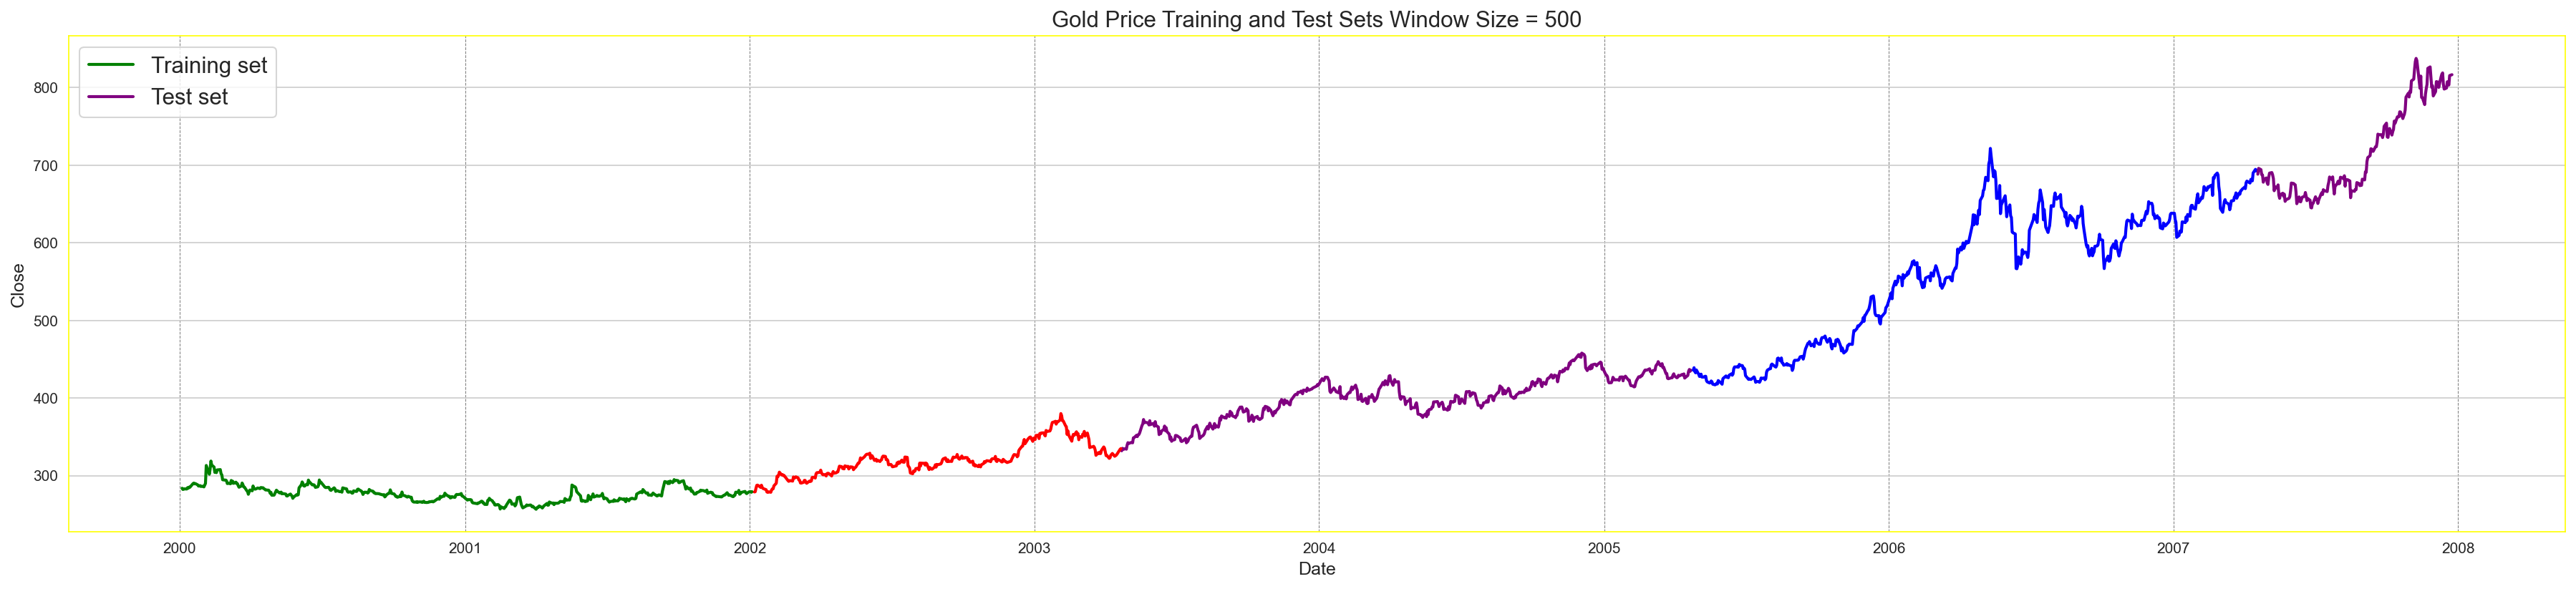

In [42]:
plot_train_test_window(gold_df[:2000], test_size, "Date", "Close")

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> Sliding Window Approach on Meachanism of 60 Day Data</h2>
</div>

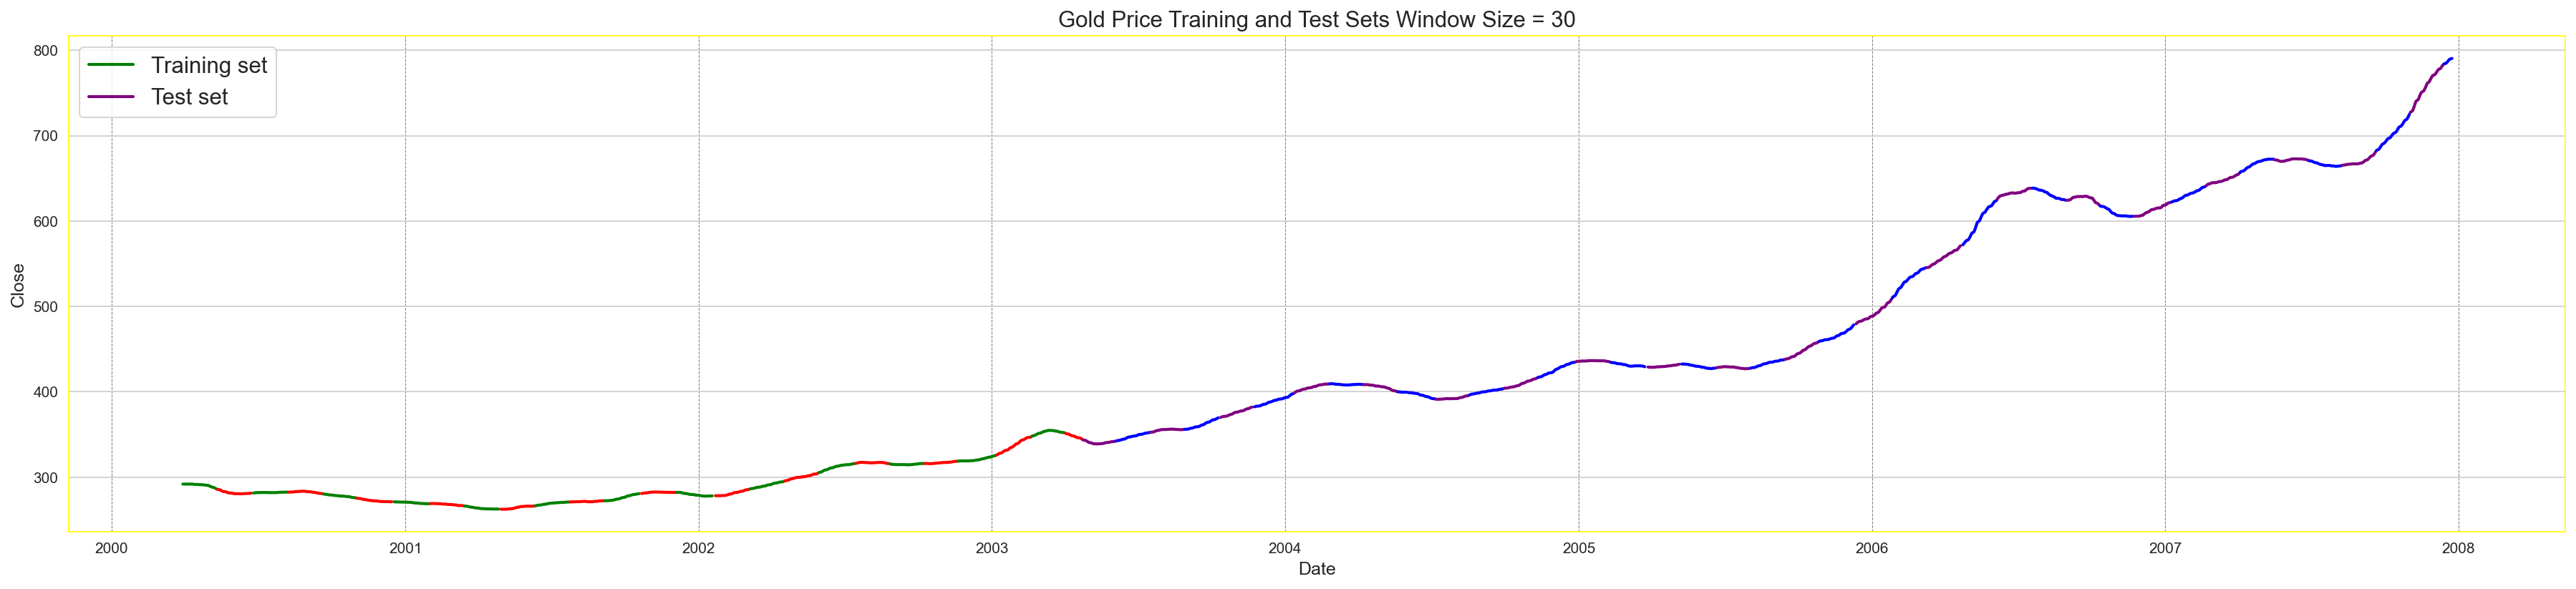

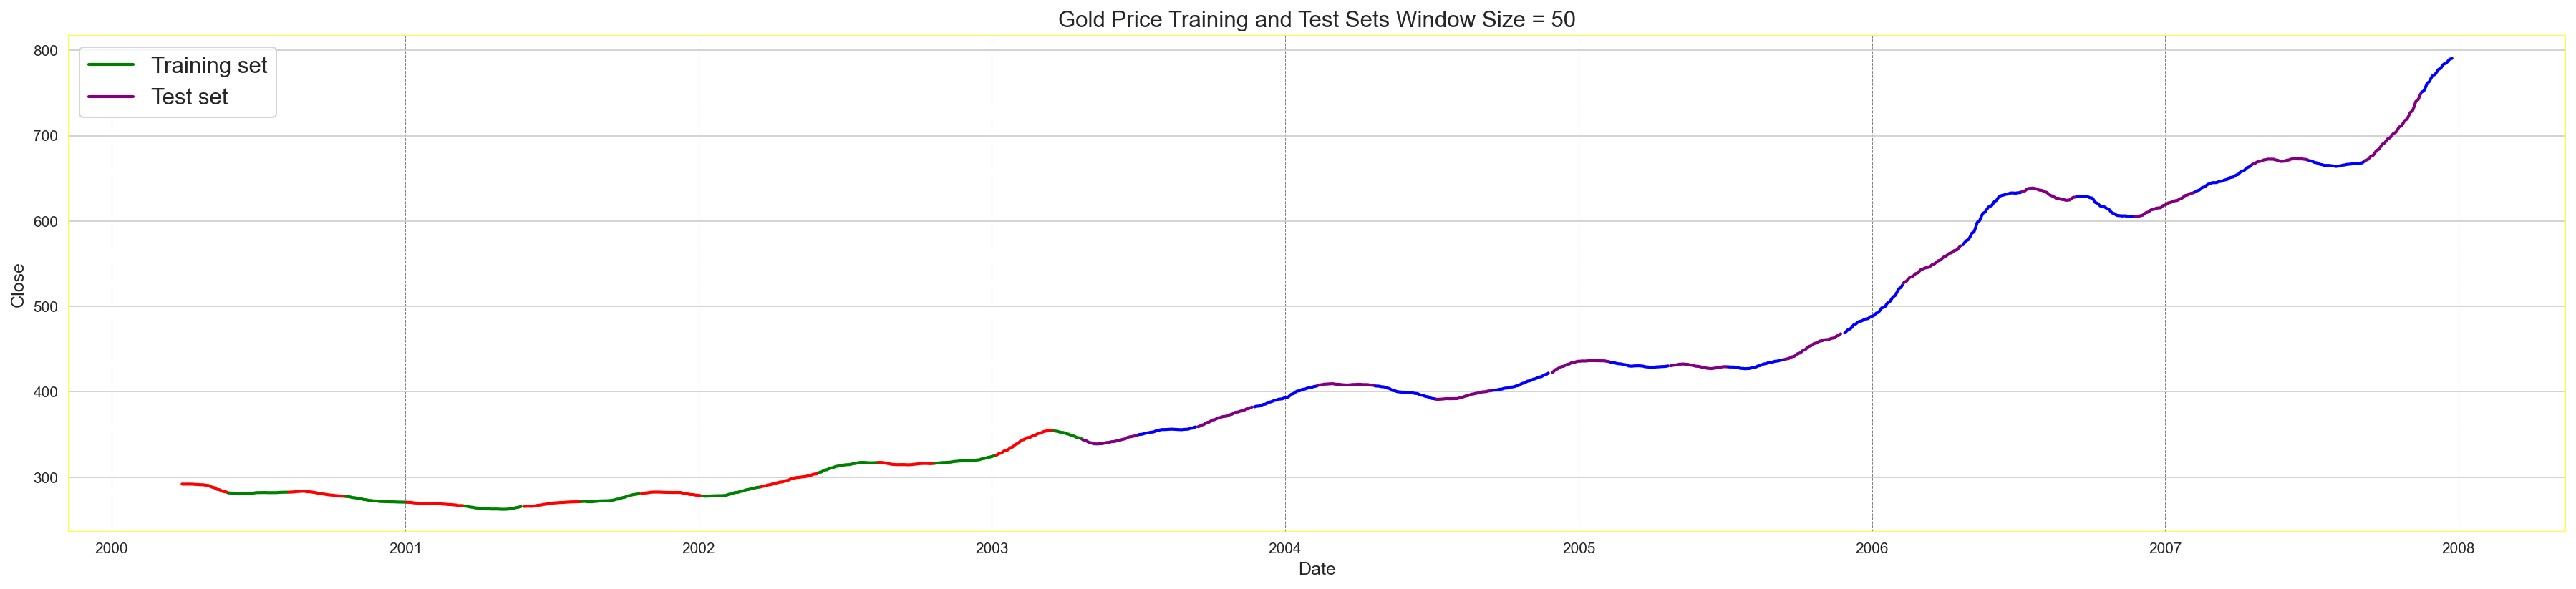

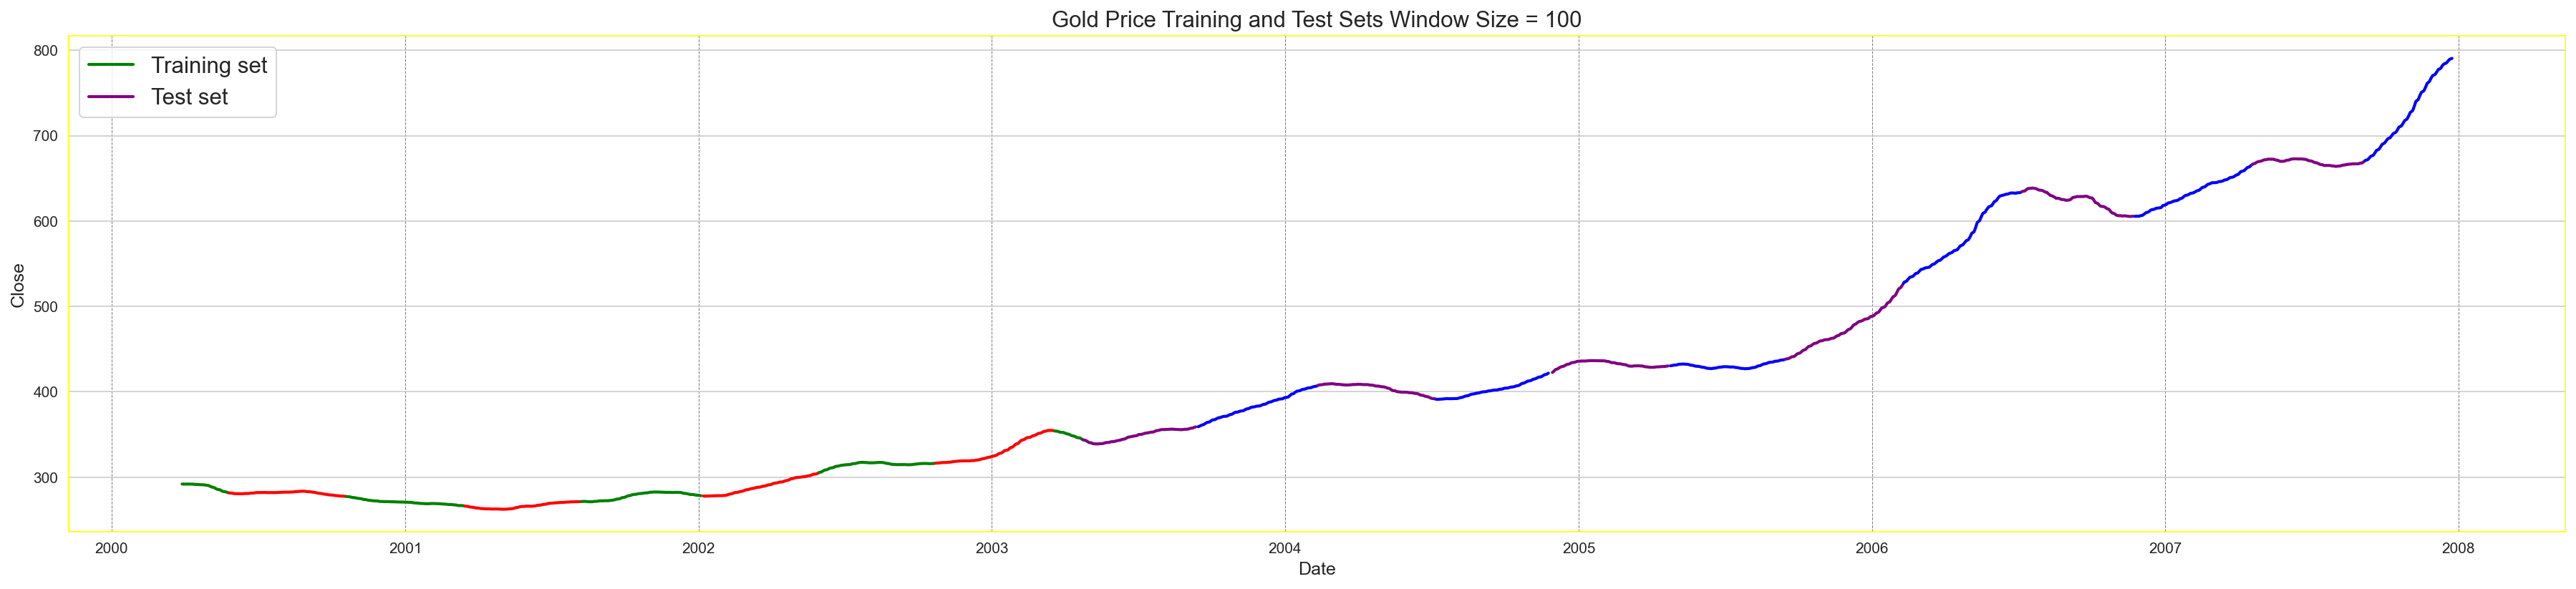

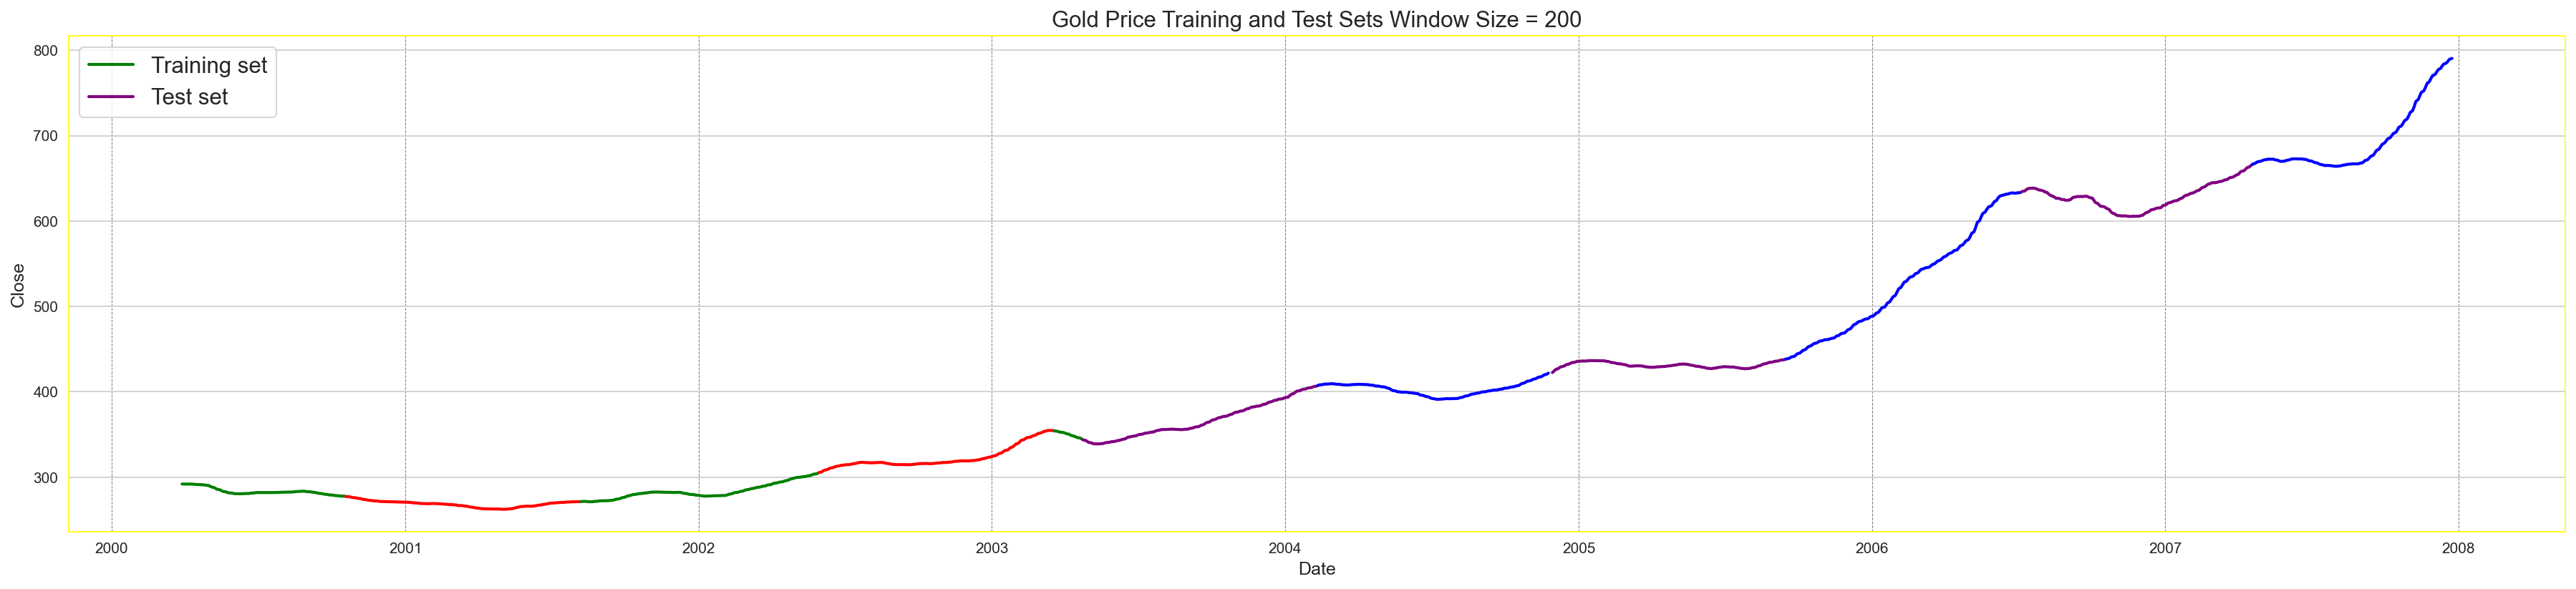

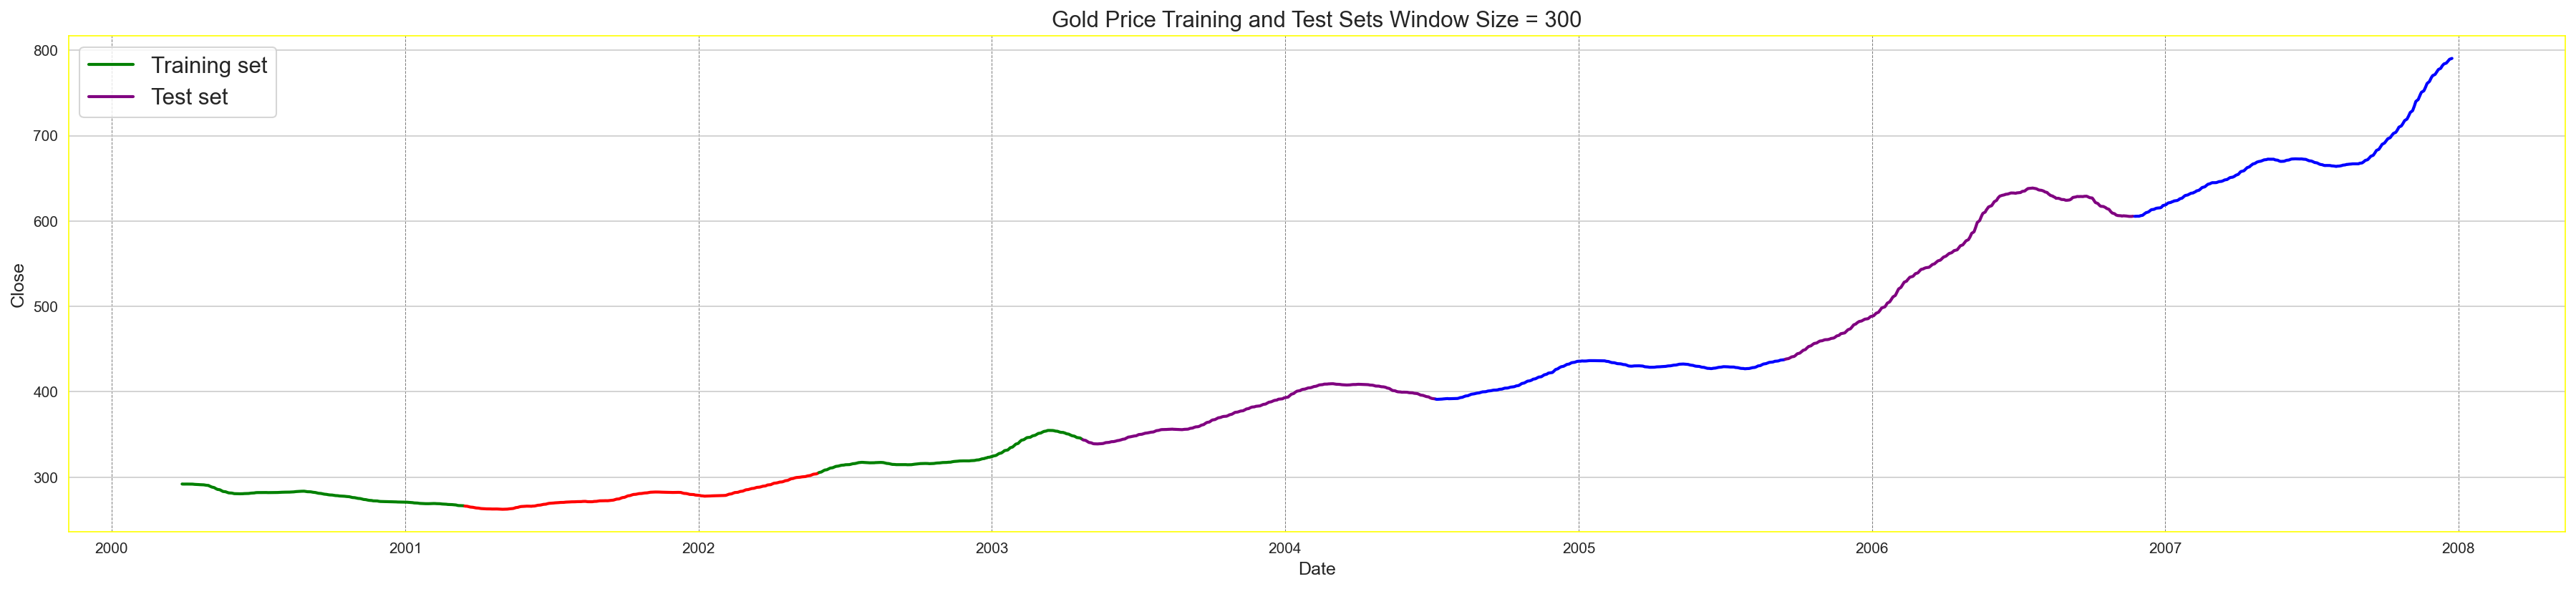

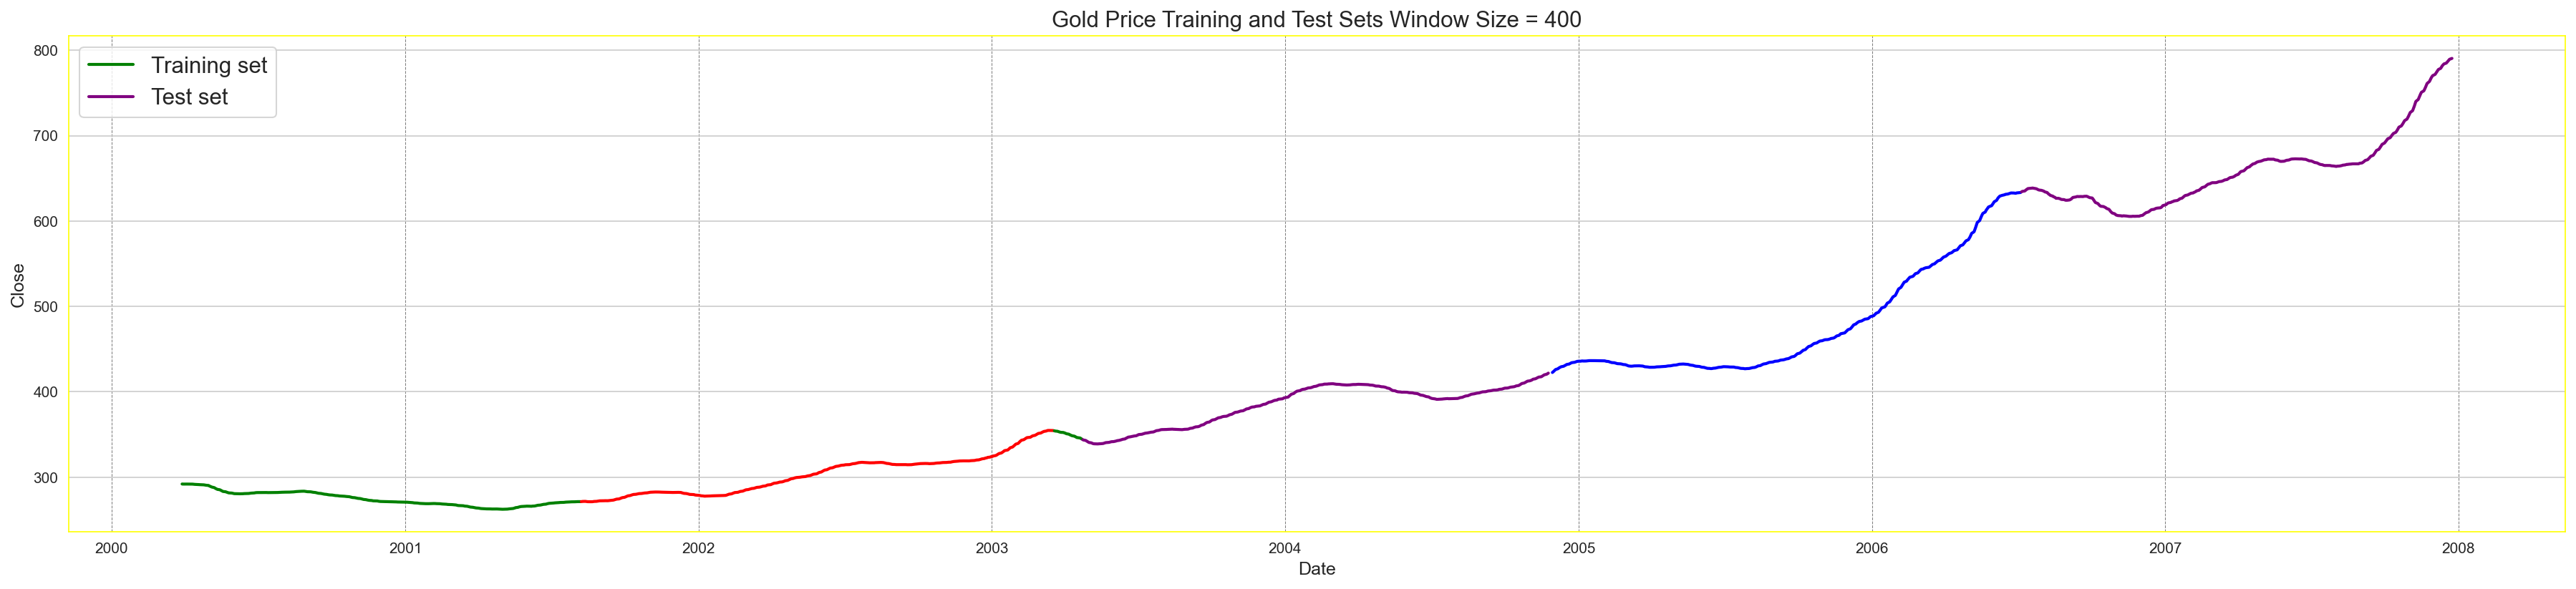

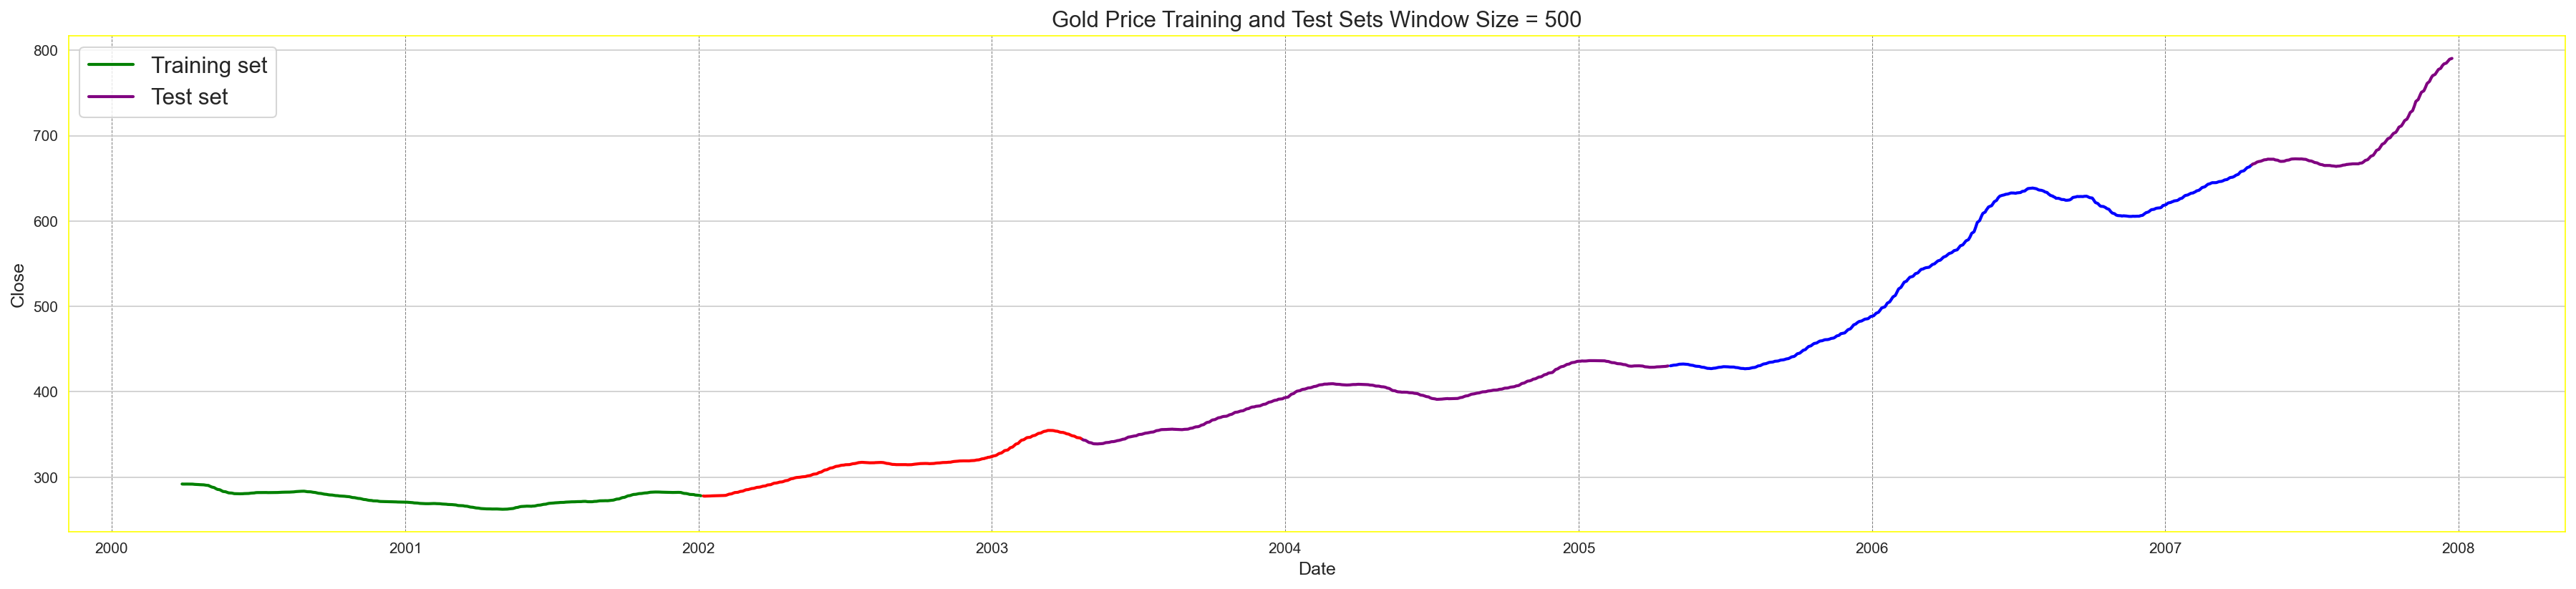

In [43]:
plot_train_test_window(gold_df[:2000], test_size, "Date", "MA_for_60_days_Close")

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> Result : 100 is selected as good window sizes</h2>
</div>

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> Make Prediction</h2>
</div>

In [44]:
class ModelLSTMClose:
    def __init__(self, df, target_feature, test_size, window_size, visualization_obj):
        self.df = df
        self.target_feature = target_feature
        self.test_size = test_size
        self.window_size = window_size
        self.model = None
        self.visualization = visualization_obj
    def create_train_test(self):
        train_data = self.df[self.target_feature][:-self.test_size]
        train_data = train_data.values.reshape(-1,1)
        test_data = self.df[self.target_feature][-(self.test_size+self.window_size):]
        test_data = test_data.values.reshape(-1,1)
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        for i in range(self.window_size, len(train_data)):
            X_train.append(train_data[i-self.window_size:i, 0])
            y_train.append(train_data[i, 0])
        for i in range(self.window_size, len(test_data)):
            X_test.append(test_data[i-self.window_size:i, 0])
            y_test.append(test_data[i, 0])        
        X_train = np.array(X_train)
        X_test  = np.array(X_test)
        y_train = np.array(y_train)
        y_test  = np.array(y_test)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        y_train = np.reshape(y_train, (-1,1))
        y_test  = np.reshape(y_test, (-1,1))
        print('X_train Shape: ', X_train.shape)
        print('y_train Shape: ', y_train.shape)
        print('X_test Shape:  ', X_test.shape)
        print('y_test Shape:  ', y_test.shape)
        return X_train, y_train, X_test, y_test
    def predict_close_LSTM(self, X_train, y_train, X_test, y_test):
        model=Sequential()
        model.add(LSTM(32, return_sequences=True, input_shape=(self.window_size, 1)))
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        print(model.summary())
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])
        self.model = model
        self.visualization.plot_history(history)
        return history
    def run_all(self):
        X_train, y_train, X_test, y_test = self.create_train_test()
        history = self.predict_close_LSTM(X_train, y_train, X_test, y_test)
        self.visualization.update(self.model, history, X_train, y_train, X_test, y_test)
        y_test, y_pred = self.visualization.print_result()
        return y_test, y_pred

X_train Shape:  (4426, 100, 1)
y_train Shape:  (4426, 1)
X_test Shape:   (1177, 100, 1)
y_test Shape:   (1177, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 100, 32)           4352      
                                                                 
 lstm_31 (LSTM)              (None, 100, 64)           24832     
                                                                 
 lstm_32 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 41,633
Trainable params: 41,633
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
70/70 [==============================] - 5s 44ms/s

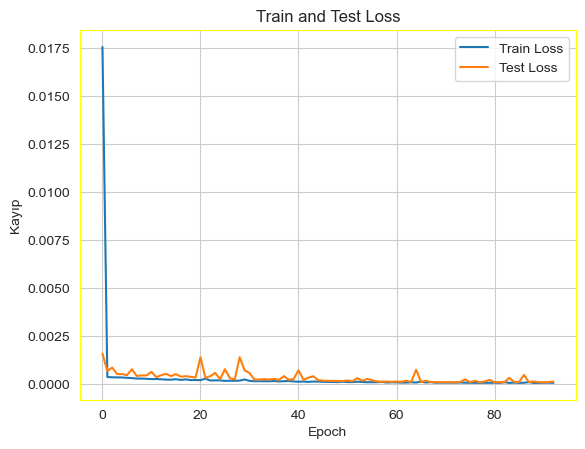

Train Result
139/139 [==============================] - 3s 17ms/step
Loss: 4.7208e-05
MAPE: 4.7208e-05
Accuracy: 0.9999527920152294
RMSE: 0.006870806704505645
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Test Result
37/37 [==============================] - 1s 18ms/step
Loss: 8.25863e-05
MAPE: 8.25863e-05
Accuracy: 0.9999174137068665
RMSE: 0.009087700101427013


In [45]:
window_size = 100
target_feature_name = "Close"
model_close_obj = ModelLSTMClose(pd.DataFrame(filled_df[target_feature_name]), target_feature_name, test_size, window_size, visualization_obj)
y_test_close, y_pred_close = model_close_obj.run_all()

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> 2 - Plot Second Approach Result</h2>
</div>

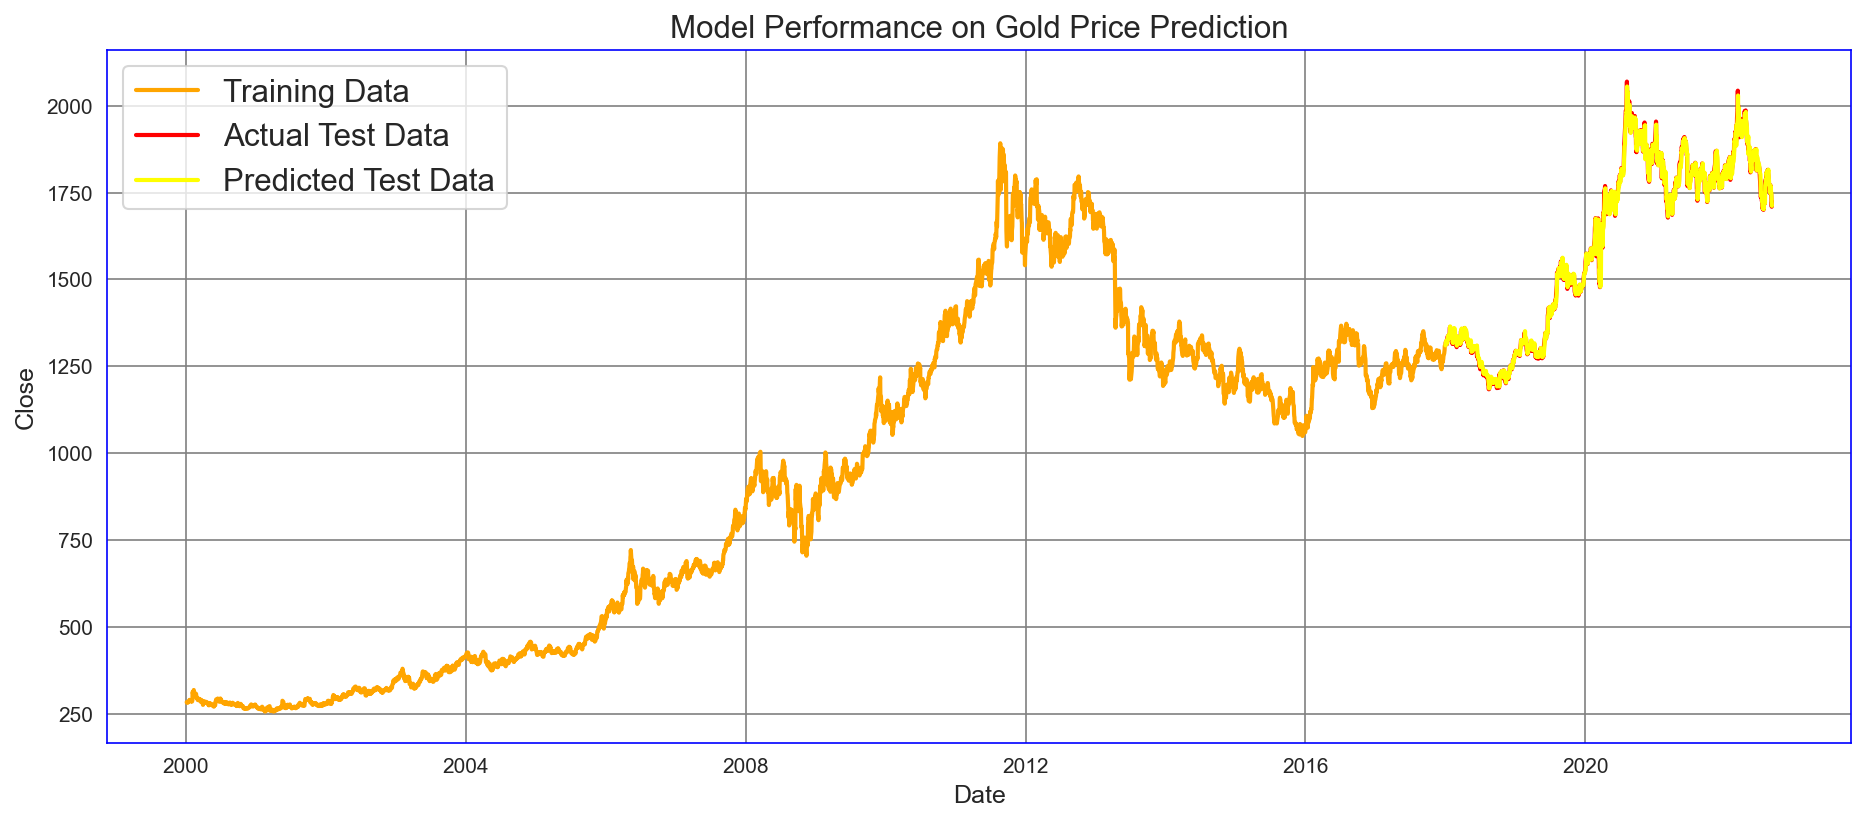

In [46]:
date_feature_name="Date"
target_feature_name="Close"
scaler = MinMaxScaler() # create scaler
scaler.fit_transform(gold_df[[target_feature_name]].values.reshape(-1,1))
visualization_df = filled_df[[date_feature_name, target_feature_name]]

plot_prediction(visualization_df, model_close_obj.test_size, date_feature_name, target_feature_name, y_test_close.reshape(-1,1), y_pred_close, scaler)

<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> 3 - LightGBM Model</h2>
</div>

In [47]:
!pip install lightgbm -q

In [57]:
def lgb_model(df, target_feature, window_size, test_size):
    train_data = df[target_feature][:-test_size]
    train_data = train_data.values.reshape(-1,1)
    test_data = df[target_feature][-(test_size+window_size):]
    test_data = test_data.values.reshape(-1,1)
    X_train_lgb = []
    y_train_lgb = []
    for i in range(window_size, len(train_data)):
        X_train_lgb.append(train_data[i-window_size:i, 0])
        y_train_lgb.append(train_data[i, 0])
    X_test_lgb = []
    y_test_lgb = []
    for i in range(window_size, len(test_data)):
        X_test_lgb.append(test_data[i-window_size:i, 0])
        y_test_lgb.append(test_data[i, 0])
    lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    lgb_model.fit(X_train_lgb, y_train_lgb)
    y_pred_lgb = lgb_model.predict(X_test_lgb)
    y_pred_train_lgb = lgb_model.predict(X_train_lgb)
    
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_lgb, y_pred_train_lgb))}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_lgb, y_pred_lgb))}") 
    y_test_lgb = np.array(y_test_lgb)
    y_test_lgb = y_test_lgb.reshape(-1,1)
    
    y_pred_lgb = np.array(y_pred_lgb)
    y_pred_lgb = y_pred_lgb.reshape(-1,1)
    MAPE = mean_squared_error(y_test_lgb, y_pred_lgb)
    Accuracy = 1 - MAPE
    print(f"Accuracy : {Accuracy}")
    return lgb_model, y_test_lgb, y_pred_lgb

In [58]:
lgb_model, y_test_lgb, y_pred_lgb = lgb_model(filled_df, target_feature_name, window_size, test_size= find_test_size(filled_df, 2018))

test size: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 4426, number of used features: 100
[LightGBM] [Info] Start training from score 0.359197
Train RMSE: 0.003974934320488614
Test RMSE: 0.045220138602538026
Accuracy : 0.9979551390647673


<div style="color: white; display: block; border-radius: 5px; background-color: #fccf03; width: 100%; height: 70%; font-size: 80%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;"> 3 - Plot Third Approach Result</h2>
</div>

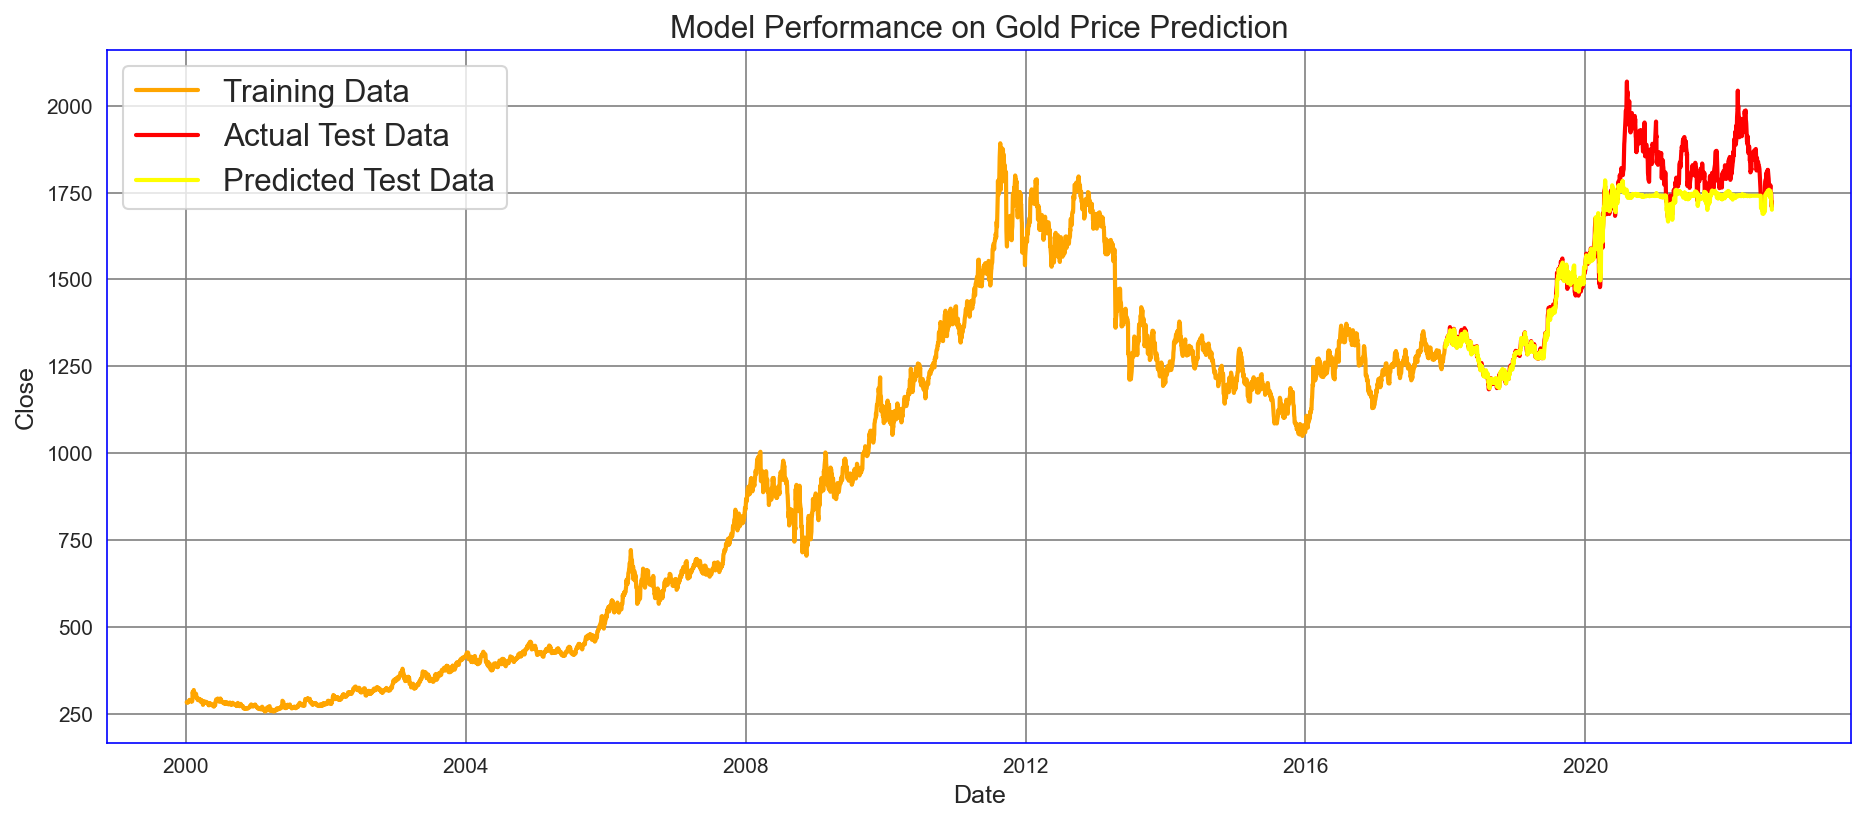

In [59]:
plot_prediction(filled_df, test_size, date_feature_name, target_feature_name, y_test_lgb, y_pred_lgb, scaler)

In [51]:
# end